# Concept of spectroscopy

## Author: Jooyeon Geem, Hyeonguk Bahk

In [8]:
import numpy as np
import os
import glob
from pathlib import Path
from matplotlib import pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table,Column
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.ndimage import median_filter
from scipy.interpolate import UnivariateSpline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.feature import peak_local_max
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
from numpy.polynomial.chebyshev import chebfit, chebval
from astropy.modeling.models import Gaussian1D, Chebyshev2D
from astropy.modeling.fitting import LevMarLSQFitter
from matplotlib import gridspec, rcParams, rc
from IPython.display import Image

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

In [453]:
# Define your working directory
HOME = Path.home()
WD = HOME/'Data'
SUBPATH = WD/'2022-11-02/'

Biaslist = sorted(list(Path.glob(SUBPATH, 'calibration*bias.fit')))

Darklist= sorted(list(Path.glob(SUBPATH, 'cali*dk*.fit')))

Flatlist = sorted(list(Path.glob(SUBPATH, 'Flat*.fit')))

Complist = sorted(list(Path.glob(SUBPATH, 'Neon*L.fit')))

Objectlist = sorted(list(Path.glob(SUBPATH, 'SN2022xkq*.fit')))

Standlist = sorted(list(Path.glob(SUBPATH, 'HR153*.fit')))

# Checking the paths
print(Table([Biaslist], names=['Bias']), 2*'\n')
print(Table([Darklist], names=['Darklist']), 2*'\n')
print(Table([Flatlist], names=['Flatlist']), 2*'\n')
print(Table([Complist], names=['Complist']), 2*'\n')
print(Table([Objectlist], names=['Objectlist']), 2*'\n')
print(Table([Standlist], names=['Standlist']), 2*'\n')

                           Bias                           
----------------------------------------------------------
/Users/hhchoi1022/Data/2022-11-02/calibration-0001bias.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-0002bias.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-0003bias.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-0004bias.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-0005bias.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-0006bias.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-0007bias.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-0008bias.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-0009bias.fit 


                          Darklist                         
-----------------------------------------------------------
 /Users/hhchoi1022/Data/2022-11-02/calibration-0001dk05.fit
  /Users/hhchoi1022/Data/2022-11-02/calibration-0001dk1.fit
 /Users/hhchoi1022/Data/2022-11-02/calibration-0001dk10.fit
/Users/hhchoi1022/Data/2022-11-02/calibration-00

# 1. Preprocessing  (i.e., Bias subtraction, Dark subtraction, Flat fielding)
## 1.1 Making master bias

Before making master bias, we have to check whethere there is a peculiar bias image.


In [10]:
# Checking the bias image
Name = []
Mean = []
Min = []
Max = []
Std = []

for i in range(len(Biaslist)):
    hdul = fits.open(Biaslist[i])
    data = hdul[0].data
    data = np.array(data).astype('float64')  # Change datatype from uint16 to float64
    mean = np.mean(data)
    minimum = np.min(data)
    maximum = np.max(data)
    stdev = np.std(data)
    print(Biaslist[i],mean,minimum,maximum)
    
    Name.append(os.path.basename(Biaslist[i]))
    Mean.append("%.2f" % mean )
    Min.append("%.2f" % minimum)
    Max.append("{0:.2f}".format(maximum))
    Std.append(f'{stdev:.2f}')
    
table = Table([Name, Mean, Min, Max, Std],
              names=['Filename','Mean','Min','Max','Std'])    
print(table)    
    


/Users/hhchoi1022/Data/2022-11-02/calibration-0001bias.fit 153.23139826839827 116.0 195.0
/Users/hhchoi1022/Data/2022-11-02/calibration-0002bias.fit 153.20317316017315 118.0 190.0
/Users/hhchoi1022/Data/2022-11-02/calibration-0003bias.fit 153.2505497835498 122.0 192.0
/Users/hhchoi1022/Data/2022-11-02/calibration-0004bias.fit 153.2186406926407 122.0 193.0
/Users/hhchoi1022/Data/2022-11-02/calibration-0005bias.fit 153.2537012987013 118.0 191.0
/Users/hhchoi1022/Data/2022-11-02/calibration-0006bias.fit 153.24992207792207 110.0 193.0
/Users/hhchoi1022/Data/2022-11-02/calibration-0007bias.fit 153.23514285714285 107.0 200.0
/Users/hhchoi1022/Data/2022-11-02/calibration-0008bias.fit 153.2132683982684 118.0 190.0
/Users/hhchoi1022/Data/2022-11-02/calibration-0009bias.fit 153.19500865800865 113.0 194.0
        Filename          Mean   Min    Max   Std 
------------------------ ------ ------ ------ ----
calibration-0001bias.fit 153.23 116.00 195.00 4.86
calibration-0002bias.fit 153.20 118.00 19

Text(0.5, 1.0, '/Users/hhchoi1022/Data/2022-11-02/calibration-0006bias.fit')

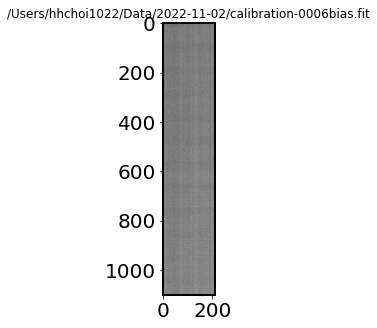

In [11]:
# Plot the Sample image of bias image
File = Biaslist[5]  # pick one of the bias image
sample_hdul = fits.open(File)
sample_data = sample_hdul[0].data

fig,ax = plt.subplots(1,1,figsize=(13,5))
vmin = np.mean(sample_data) - 40
vmax = np.mean(sample_data) + 40
im = ax.imshow(sample_data,
               cmap='gray', vmin=vmin, vmax=vmax)
ax.set_title(File, fontsize=12)

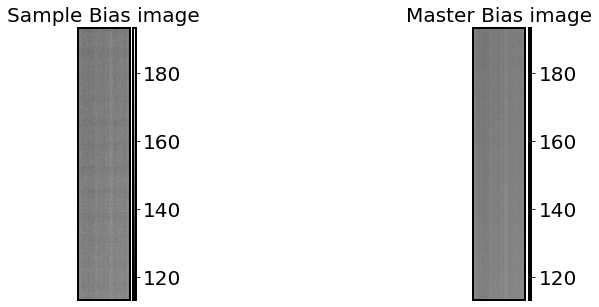

In [12]:
# Median combine Bias image    
    
Master_bias = []
for i in range(0,len(Biaslist)):
    hdul = fits.open(Biaslist[i])
    bias_data = hdul[0].data
    bias_data = np.array(bias_data).astype('float64')
    Master_bias.append(bias_data)
MASTER_Bias = np.median(Master_bias,axis=0)


# Let's make Master bias image fits file

# Making header part
bias_header = hdul[0].header  # fetch header from one of bias images
bias_header['OBJECT'] = 'Bias'
# - add information about the combine process to header comment
bias_header['COMMENT'] = f'{Biaslist} bias images are median combined on ' \
                          + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')


SAVE_bias = SUBPATH/'Master_Bias.fits'  # path to save master bias
fits.writeto(SAVE_bias, MASTER_Bias, header=bias_header, overwrite=True)


# Plot Master bias 
fig,ax = plt.subplots(1, 2, figsize=(13,5))
im = ax[0].imshow(sample_data, cmap='gray',
                  vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Sample Bias image', fontsize=20)
ax[0].tick_params(labelbottom=False, labelleft=False,
                  bottom=False, left=False)
plt.colorbar(im,cax=cax)

im1 = ax[1].imshow(MASTER_Bias, cmap='gray',
                   vmin=vmin, vmax=vmax)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size='5%', pad=0.05)
ax[1].set_title('Master Bias image',fontsize=20)
ax[1].tick_params(labelbottom=False, labelleft=False,
                  bottom=False, left=False)
plt.colorbar(im1, cax=cax)


## 1.2 Derive Readout Noise (RN)

In [13]:
# Let's derive RN

# The following is just to give you an idea about the calculation
# - Bring Bias1 data
hdul1 = fits.open(Biaslist[0]) 
bias1 = hdul1[0].data            
bias1 = np.array(bias1).astype('float64')

# - Bring Bias2 data
hdul2 = fits.open(Biaslist[1])
bias2 = hdul2[0].data
bias2 = np.array(bias2).astype('float64')

# - Derive the differential image
dbias = bias2 - bias1

# - Bring Gain 
gain = 1.5 #e/ADU

# - Calculate RN
RN = np.std(dbias)*gain / np.sqrt(2)
print(f'Readout Noise is {RN:.2f}')



# Let's do it for all bias data
Name = []
RN = []
for i in range(len(Biaslist)-1):
    hdul1 = fits.open(Biaslist[i])
    bias1 = hdul1[0].data
    bias1 = np.array(bias1).astype('float64')
    hdul2 = fits.open(Biaslist[i+1])
    bias2 = hdul2[0].data
    bias2 = np.array(bias2).astype('float64')
    dbias = bias2 - bias1

    print(i,'st',np.std(dbias)*gain / np.sqrt(2))
    RN.append(np.std(dbias)*gain / np.sqrt(2))
print('\nmean RN:', np.mean(RN))    
RN = np.mean(RN)

Readout Noise is 6.29
0 st 6.288772452234146
1 st 6.277357079256295
2 st 6.293243825551757
3 st 6.302840672244455
4 st 6.287938245063721
5 st 6.285597150962633
6 st 6.3119484978421845
7 st 6.306560815548025

mean RN: 6.294282342337902


## 1.3 Making Master Dark
Master dark = median combine([Dark image1 - master bias, Dark image2 - master bias, Dark image3 - master bias,...])

In [14]:
# Checking what exposure time is taken
exptime = []

for i in range(len(Darklist)):
    hdul = fits.open(Darklist[i])[0]
    header = hdul.header
    exp = header['EXPTIME']  # get exposure time from its header 
    exptime.append(exp)
exptime = set(exptime)  # only unique elements will be remained
exptime = sorted(exptime)
print(exptime)

[0.05, 1.0, 3.0, 5.0, 10.0, 15.0, 30.0, 60.0, 120.0, 600.0, 900.0]


In [15]:
# Bring master bias
Mbias = fits.open(SAVE_bias)[0].data
Mbias = np.array(Mbias).astype('float64')

# Making master dark image for each exposure time
for exp_i in exptime:
    Master_dark = []
    for i in range(len(Darklist)):
        hdul = fits.open(Darklist[i])[0]
        header = hdul.header
        exp = header['EXPTIME']

        if exp == exp_i:
            data = hdul.data
            data = np.array(data).astype('float64')
            bdata = data - Mbias  # bias subtracting
            Master_dark.append(bdata)
            
    MASTER_dark = np.median(Master_dark, axis=0)  # median combine bias-subtracted dark frames
    
    header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    header["COMMENT"] = f'{len(Master_dark)} dark images are median combined on '\
                         + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    
    SAVE_dark = SUBPATH/('Master_Dark_'+str(exp_i)+'s.fits')
    fits.writeto(SAVE_dark, MASTER_dark, header=header, overwrite=True)
    print(exp_i ,'s is done!', SAVE_dark,' is made.')

0.05 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_0.05s.fits  is made.
1.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_1.0s.fits  is made.
3.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_3.0s.fits  is made.
5.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_5.0s.fits  is made.
10.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_10.0s.fits  is made.
15.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_15.0s.fits  is made.
30.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_30.0s.fits  is made.
60.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_60.0s.fits  is made.
120.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_120.0s.fits  is made.
600.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_600.0s.fits  is made.
900.0 s is done! /Users/hhchoi1022/Data/2022-11-02/Master_Dark_900.0s.fits  is made.


## 1.4 Making Master Flat

### 1.4-1 Checking whether Flat image is shifted or not
The flat image could shift little by little depending on where the telescope is pointing. Because different images may have different flats to use, it can be dangerous to median combine all the flats image taken overnight. Let's do **quick** and **rough** check whethere there is flat shift.

By using local peak location, I will check whether there was the flat shift or not. 

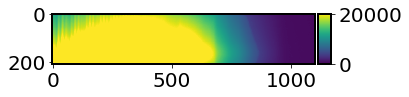

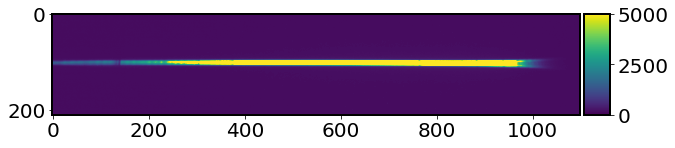

In [17]:
#Plot the flat image
fig,ax = plt.subplots(1, 1, figsize=(5, 5))

hdul = fits.open(Flatlist[4])[0]
data = hdul.data
im = ax.imshow(data.T, vmin=0, vmax=20000)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right" ,size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

# Standard star
fig,ax = plt.subplots(1, 1, figsize=(10, 5))
hdul = fits.open(Standlist[2])[0]
data = hdul.data
im = ax.imshow(data.T, vmin=0, vmax=5000)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right" ,size='5%', pad=0.05)
plt.colorbar(im, cax=cax)

(0.0, 1100.0)

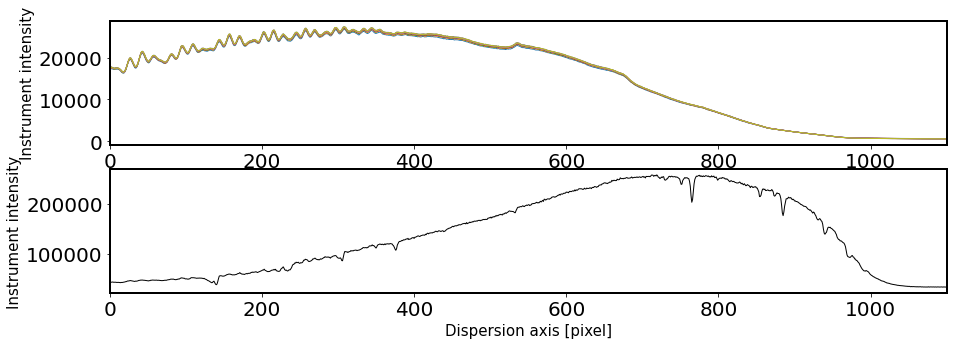

In [22]:
# Checking intensity profile through the dispersion axis

fig,ax = plt.subplots(2,1,figsize=(15,5))

for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    data = hdul.data.astype('float64')
    flat = np.mean(data, axis=1)
    
    ax[0].plot(flat, label=Flatlist[i].name, lw=1)
    #ax[0].legend(fontsize=10)
    ax[0].set_ylabel('Instrument intensity')
    ax[0].set_xlabel('Dispersion axis [pixel]')
ax[0].set_xlim(0, 1100)

hdul_std = fits.open(Standlist[0])[0]
data_std = hdul_std.data.astype('float64')
std = np.sum(data_std,axis=1)
ax[1].plot(std, label=Standlist[0].name, lw=1, c='k')
ax[1].set_ylabel('Instrument intensity')
ax[1].set_xlabel('Dispersion axis [pixel]')
ax[1].set_xlim(0, 1100)
# ax.set_ylim(0, 21000)
    

####  Comparing with the Standard Star Profile

The above flat spectra shows many wiggles and bumps. Yet, we don't know if these features are originated from the grating, which in turn will affect our science frame equally. If they are not due to the grating, such as filters in front of the flat-field lamp, the extreme difference in color temperature between the lamps and the object of interest, or wavelength-dependent variations in the reflectivity of the paint used for the flat-field screen ([Massey & Hansen, 2010](https://arxiv.org/abs/1010.5270)), they are not going to present on the science frame. 

Let's see if a supposedly smooth source (in this case, a standard star) has same "wiggles" and "bumps" on its spectrum. If this is the case, we should model the flat lamp with "high order" and normalize the flat image with this model. If not, we should adopt "low-order" model or constant to normalize our flat field.

Text(0.8, 0.7, 'Bump not originated \n from the grating')

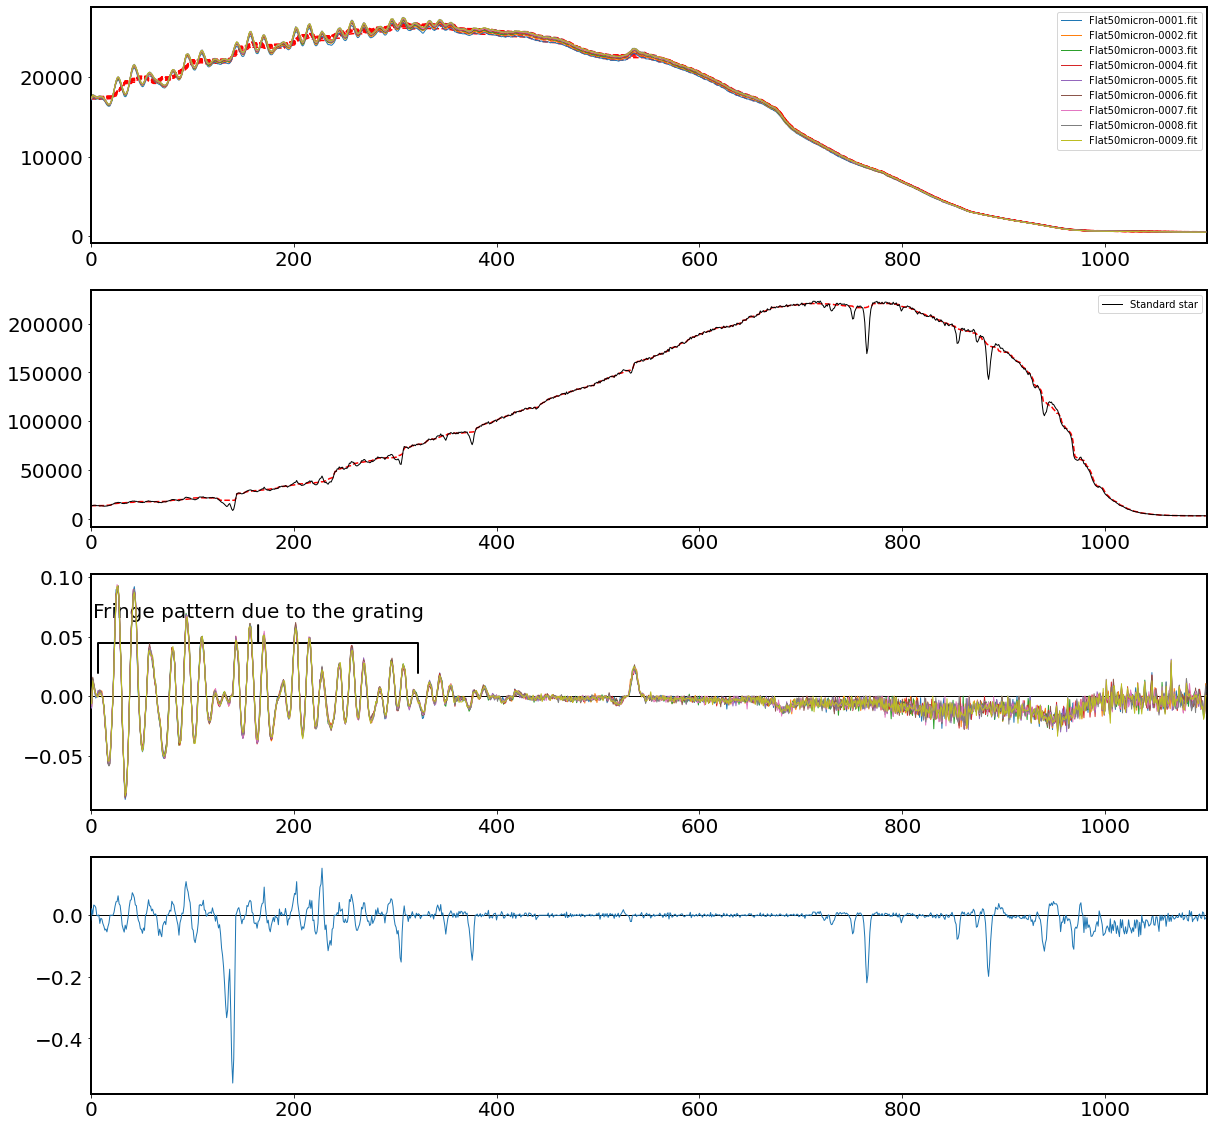

In [27]:
fig,ax = plt.subplots(4,1,figsize=(20,20))

def smooth(y, width):    # Moving box averaging
    box = np.ones(width)/width
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth   

smoothing_size = 30
smoother = median_filter

Coor_shift = []
for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    data = hdul.data.astype('float64')
    flat = np.mean(data, axis=1)
    
    ax[0].plot(flat,label=Flatlist[i].name, lw=1, zorder=20)
    ax[0].set_xlim(0, 1100)
    ax[0].legend(fontsize=10)
    
    sflat = smoother(flat, smoothing_size)
    nor_flat = flat/sflat  # flat field normalized by smoothed curve
    ax[0].plot(sflat, color='r', ls='--')
    
    ax[2].plot((flat-sflat)/sflat, lw=1, zorder=15, label=Flatlist[i].name)
    #ax[2].legend(fontsize=10)
    ax[2].set_xlim(0, 1100)
    ax[2].axhline(0, color='k', lw=1)

# Let's see if a supposedly smooth source (in this case, a standard star)
# has same "wiggles" and "bumps" on its spectrum. If this is the case, we should
# model the flat lamp with "high order" and normalize the flat image with the model.
# If not, we 
sstd = smoother(std, smoothing_size)

ax[1].plot(std,label='Standard star', c='k', lw=1, zorder=20)
ax[1].plot(sstd, color='r', ls='--')
ax[1].set_xlim(0, 1100)
ax[1].legend(fontsize=10)
    
ax[3].plot((std-sstd)/sstd, lw=1, zorder=15)
ax[3].set_xlim(0, 1100)
ax[3].axhline(0, color='k', lw=1)

ax[2].annotate('Fringe pattern due to the grating', xy=(0.15, 0.7), xytext=(0.15, 0.8), xycoords='axes fraction', 
               fontsize=20, ha='center', va='bottom',
               arrowprops=dict(arrowstyle='-[, widthB=8.0, lengthB=1.5', lw=2.0))
ax[2].annotate('Bump not originated \n from the grating', xy=(1270, 0.1),  xycoords='data',
               xytext=(0.8, 0.7), textcoords='axes fraction', fontsize=20,
               arrowprops=dict(facecolor='black', shrink=0.05),
               ha='right', va='bottom')

### 1.4-2 Median combine flat image to make Master Flat

Note that in our flat frame, both grating-originated wiggles and the lamp-originated bump can be found. Thus we need to account for these effect simultaneously in order to appropriately flat-field our science frame. However, this will be very cumbersome because we need to model our flat spectrum in different regions.

So here we just adopt smoothed flat spectrum with large smoothing scale to normalize the flat (this will effectively play a role of "low-order" fitting), ignoring the bump of the lamp. This will make reduced science spectrum have the bump feature at same location on the dispersion axis.

In [48]:
MASTER_flat.shape

(1100, 210)

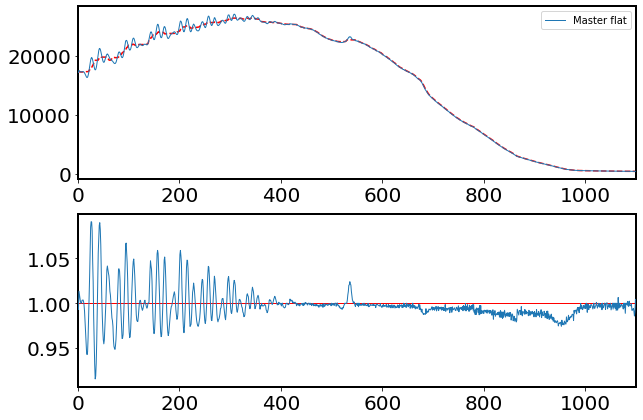

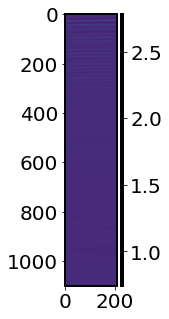

In [50]:
# Bring Master bias & Dark

biasfile = SUBPATH/'Master_Bias.fits'
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

darkfile = SUBPATH/'Master_Dark_15.0s.fits' # check the exposure time for your flat frames
Mdark = fits.open(darkfile)[0].data
Mdark = np.array(Mdark).astype('float64')


# Make master Flat image
Master_flat = []
for i in range(len(Flatlist)):
    hdul = fits.open(Flatlist[i])[0]
    header = hdul.header
    
    data = hdul.data
    data = np.array(data).astype('float64')
    
    bdata = data - Mbias    # bias subtraction
    dbdata = bdata - Mdark  # dark subtraction
    Master_flat.append(dbdata)
    
MASTER_flat = np.median(Master_flat,axis=0)
header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
header["COMMENT"] = f'{len(Master_dark)} dark images are median combined on '\
                    + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')+'with '+' Master_Dark_'+str(exp)+'s.fits'




flat = np.mean(MASTER_flat,axis=1)
fig,ax=plt.subplots(2,1,figsize=(10,7))
ax[0].plot(flat,label='Master flat',lw=1,zorder=20)
ax[0].set_xlim(0,1100)
ax[0].legend(fontsize=10)

sflat = median_filter(flat, 30) # median filtering scale should be defined interactively
nor_flat = flat/sflat
ax[0].plot(sflat,color='r',ls='--')

ax[1].plot(nor_flat,lw=1,zorder=15)
ax[1].set_xlim(0,1100)
ax[1].axhline(1,color='r',lw=1)    

nor_flat2d = []
for i in range(len(MASTER_flat[0])):
    flat = MASTER_flat[:,i]
    sflat = median_filter(flat, 30) # this might work better for cutout frames
    nor_flat2d.append(flat / sflat)
    
nor_flat2d = np.array(nor_flat2d).T    
header['COMMENT'] = 'Normalized' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')

SAVE_flat = SUBPATH/'Master_Flat.fits'
fits.writeto(SAVE_flat, nor_flat2d, header=header, overwrite=True)



fig,ax = plt.subplots(1,1,figsize=(5,5))
im=ax.imshow(nor_flat2d)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)


## 1.5 Master Calibration image
### Check wavelength Calibration image shift

I will check the wavelength calibration image shift with the same manner done for flat image.

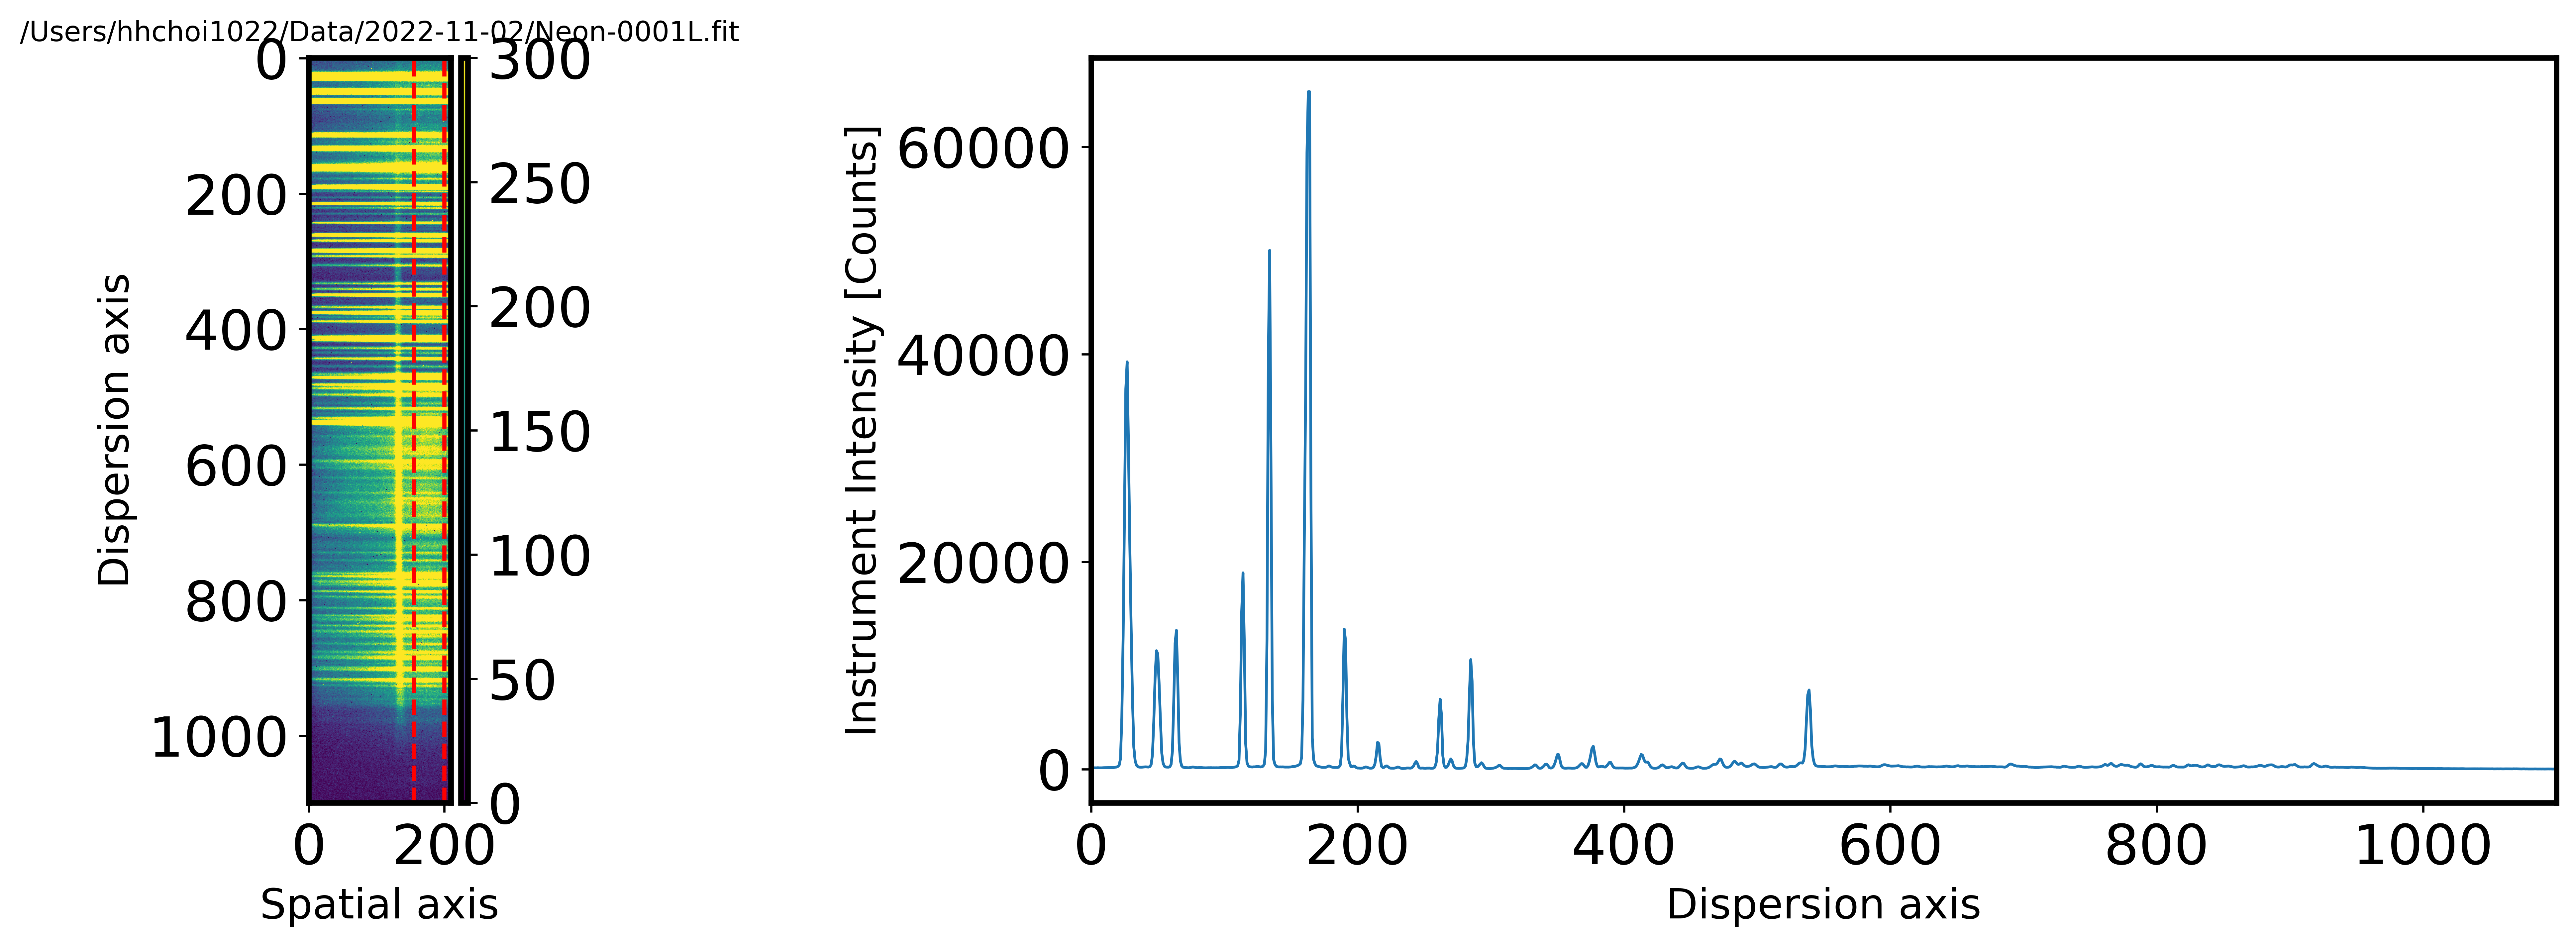

In [51]:
#Bring Master bias & Dark

biasfile = os.path.join(SUBPATH,'Master_Bias.fits')
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

darkfile = os.path.join(SUBPATH,'Master_Dark_120.0s.fits')
Mdark = fits.open(darkfile)[0].data 
Mdark = np.array(Mdark).astype('float64')

#Plot the Comparison image
neon_range_min = 155
neon_range_max = 200
fig,ax = plt.subplots(1,2,figsize=(15,5), dpi =600)

hdul = fits.open(Complist[0])[0]
data = hdul.data
data = np.array(data).astype('float64')
data = data - Mbias - Mdark

im = ax[0].imshow(data,vmin=0, vmax = 300)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right",size='5%',pad=0.05)
plt.colorbar(im,cax=cax)
ax[0].axvline(neon_range_min, linestyle = '--', c= 'r')
ax[0].axvline(neon_range_max, linestyle = '--', c= 'r')
ax[0].set_title(Complist[0],fontsize=10)
ax[0].set_xlabel('Spatial axis')
ax[0].set_ylabel('Dispersion axis')

#Cut the spectrum along the dispersion direction
ComSpec = np.median(data[:,neon_range_min:neon_range_max],axis=1)
ax[1].plot(ComSpec,lw=1)
ax[1].set_xlim(0,1100)
ax[1].set_xlabel('Dispersion axis')
ax[1].set_ylabel('Instrument Intensity [Counts]')
    
plt.tight_layout()

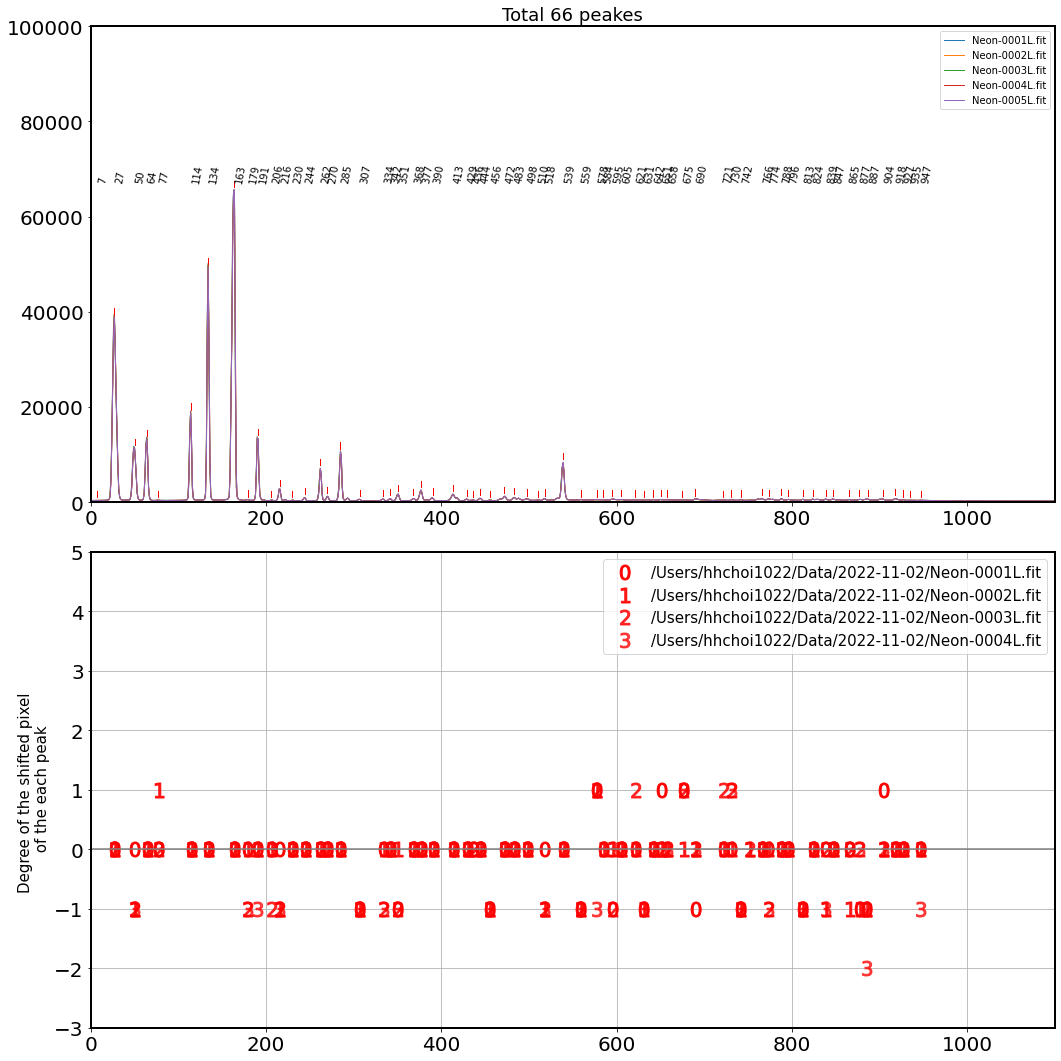

In [55]:
# Find the local peak for each image

fig,ax = plt.subplots(2,1,figsize=(15,15))
Coor_shift = []
for i in range(len(Complist)):
    hdul = fits.open(Complist[i])[0]
    data = hdul.data
    data = np.array(data).astype('float64')
    neon = np.median(data[:,neon_range_min: neon_range_max],axis=1)
    
    ax[0].plot(neon,label=Complist[i].name,lw=1)
    ax[0].set_xlim(0,1100)
    ax[0].legend(fontsize=10)
    ax[0].set_ylim(0,100000)
    
    
    x = np.arange(0,len(neon))
    # peak finding
    coordinates = peak_local_max(neon, min_distance=5, 
                                 threshold_abs= max(neon)*0.005)
    
    Coor_shift.append(coordinates) # to compare peak locations frame by frame
    
    

ax[0].set_title('Total {0} peakes'.format(int(len(coordinates))))

for i in coordinates:
    ax[0].annotate(i[0],(i,max(neon)+ max(neon)*0.03),
                  fontsize=10,rotation=80)
    ax[0].plot([i,i],
            [neon[i] + max(neon)*0.01, neon[i] + max(neon)*0.03],
            color='r',lw=1)
    
    
reference_coor = sorted(Coor_shift[0])    
     
for i in range(len(Coor_shift)-1):
    coor_i = Coor_shift[i+1]
    x_shift = []
    y_shift = []
    for k in range(len(reference_coor)):
        for t in range(len(coor_i)):
            if abs(reference_coor[k]-coor_i[t]) <5 :
                y_shift.append(reference_coor[k]-coor_i[t])
                x_shift.append(reference_coor[k])
    ax[1].plot(x_shift,y_shift,ls='',marker=f'${int(i)}$',
               markersize=15,color='r',alpha=1-i*0.1, label=Complist[i])    
ax[1].set_xlim(0,1100)    
ax[1].set_ylim(-3,5)
ax[1].set_ylabel('Degree of the shifted pixel \n of the each peak')
ax[1].axhline(0,color='gray')
ax[1].grid()
ax[1].legend()

plt.tight_layout()

### Median combine Comparison Lamp image

In [57]:
Master_Comp = []
for i in range(len(Complist)):
    hdul = fits.open(Complist[i])[0]
    header = hdul.header    
    data = hdul.data
    data = data - Mbias - Mdark

    Master_Comp.append(data)
    
MASTER_Comp = np.median(Master_Comp,axis=0)
SAVE_comp = os.path.join(SUBPATH,'Master_Neon.fits')
fits.writeto(SAVE_comp,MASTER_Comp,header = header,overwrite=True)


## 1.6 Bias subtraction & Dark subtraction (Pre-Processing)

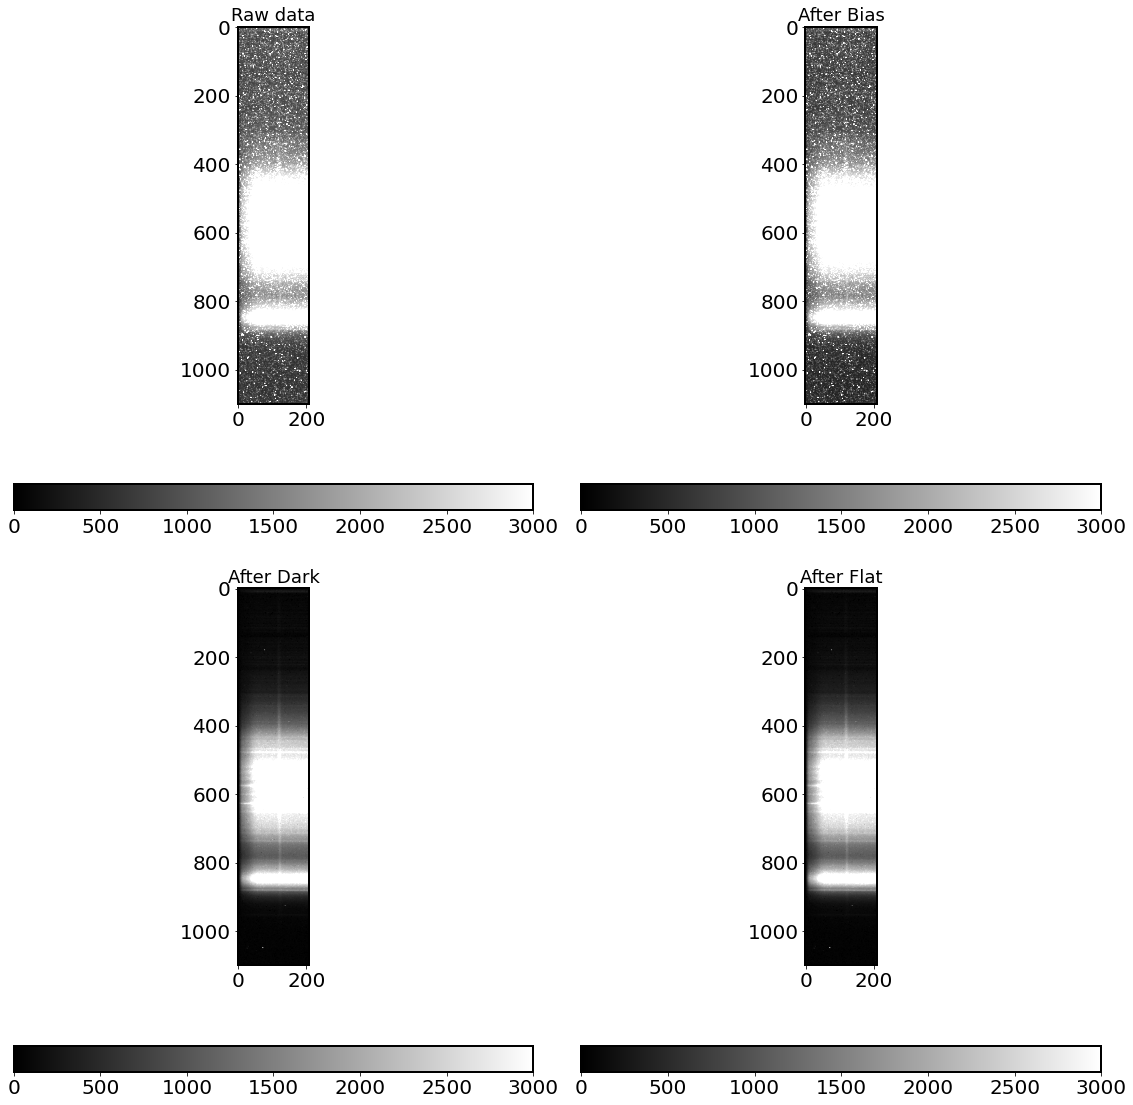

In [58]:
# Bring the sample image 
raw_data = SUBPATH/'SN2022xkq-0001.fit'
objhdul = fits.open(raw_data)
raw_data = objhdul[0].data

# Bring Master Bias
biasfile = SUBPATH/'Master_Bias.fits'
Mbias = fits.open(biasfile)[0].data
Mbias = np.array(Mbias).astype('float64')

# Bring Master Dark
darkfile = SUBPATH/'Master_Dark_900.0s.fits'
Mdark = fits.open(darkfile)[0].data 
Mdark = np.array(Mdark).astype('float64')

# Bring Master Flat
flatfile = SUBPATH/'Master_Flat.fits'
Mflat = fits.open(flatfile)[0].data 
Mflat = np.array(Mflat).astype('float64')


# Bias subtracting
bobjdata = raw_data - Mbias 

# Dark_subtracting
dbobjdata = bobjdata - Mdark

# Flat fielding
fdbobjdata = dbobjdata/Mflat


fig,ax = plt.subplots(2,2,figsize=(16,16))
ax1 = ax[0,0].imshow(raw_data,vmin=0,vmax=3000,cmap='gray')
fig.colorbar(ax1, ax=ax[0,0],orientation = 'horizontal')
ax[0,0].set_title('Raw data')


ax2 = ax[0,1].imshow(bobjdata,vmin=0,vmax=3000,cmap='gray')
fig.colorbar(ax2, ax=ax[0,1],orientation = 'horizontal')
ax[0,1].set_title('After Bias')

ax3 = ax[1,0].imshow(dbobjdata,vmin=0,vmax=3000,cmap='gray')
fig.colorbar(ax3, ax=ax[1,0],orientation = 'horizontal')
ax[1,0].set_title('After Dark')

ax4 = ax[1,1].imshow(fdbobjdata,vmin=0,vmax=3000,cmap='gray')
fig.colorbar(ax3, ax=ax[1,1],orientation = 'horizontal')
ax[1,1].set_title('After Flat')

plt.tight_layout()

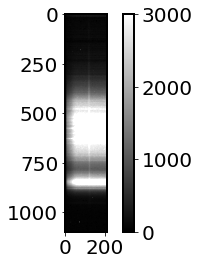

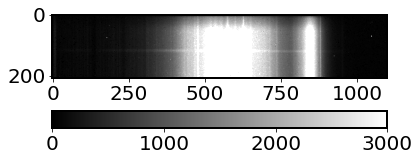

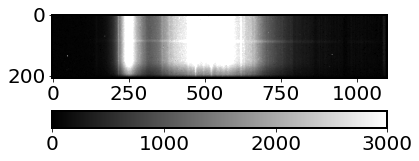

In [59]:
# Trimming
Trim = dbobjdata
fig,ax = plt.subplots(1,1)
im = ax.imshow(Trim,vmin=0,vmax=3000,cmap='gray')
fig.colorbar(im, ax=ax)

Turn = Trim.T
fig,ax = plt.subplots(1,1)
im = ax.imshow(Turn,vmin=0,vmax=3000,cmap='gray')
fig.colorbar(im, ax=ax,orientation = 'horizontal')

Flip = np.flip(Turn)
fig,ax = plt.subplots(1,1)
im = ax.imshow(Flip,vmin=0,vmax=3000,cmap='gray')
fig.colorbar(im, ax=ax,orientation = 'horizontal')


In [61]:
# Do it for all object image

OBJ = np.concatenate([Objectlist,Standlist])
for i in range(len(OBJ)):
    # Bring the sample image 
    objhdul = fits.open(OBJ[i])
    raw_data = objhdul[0].data
    header = objhdul[0].header

    # Bring Master Bias
    biasfile = SUBPATH/'Master_Bias.fits'
    Mbias = fits.open(biasfile)[0].data
    Mbias = np.array(Mbias).astype('float64')

    # Bring Master Dark
    EXPTIME = objhdul[0].header['EXPTIME']
    darkfile = SUBPATH/f'Master_Dark_{EXPTIME:.1f}s.fits'
    Mdark = fits.open(darkfile)[0].data 
    Mdark = np.array(Mdark).astype('float64')

    # Bias subtracting
    bobjdata = raw_data - Mbias 

    # Dark_subtracting
    dbobjdata = bobjdata - Mdark
    
    # Trim the image 
    Trim = dbobjdata
    
    #Rotate and Filp the image 
    Turn = Trim.T
    Flip = np.flip(Turn)
    
    # Add header comment
    header['COMMENT'] = 'Bias_subtraction is done' + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')
    header["COMMENT"]='{0} dark images are median combined on '.format(len(Master_dark))\
    + datetime.now().strftime('%Y-%m-%d %H:%M:%S (KST)')+ 'with '+' Master_Dark_'+str(exp)+'s.fits'
    
    # Save the image
    SAVE_name = SUBPATH/('p'+ OBJ[i].name+'s')
    fits.writeto(SAVE_name,Flip,header = header,overwrite=True)
    print(SAVE_name,' is made!')

    
# Trim the Neon image
Master_comparison = SUBPATH/'Master_Neon.fits'
hdul = fits.open(Master_comparison)[0]
data = hdul.data
tdata = data
Turn = tdata.T
Flip = np.flip(Turn)

fits.writeto(SUBPATH/'pMaster_Neon.fits',Flip,header=hdul.header,overwrite=True)

/Users/hhchoi1022/Data/2022-11-02/pSN2022xkq-0001.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pSN2022xkq-0002.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pSN2022xkq-0003.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pSN2022xkq-0004.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pSN2022xkq-0005.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0001.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0002.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0003.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0004.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0005.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0006.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0007.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0008.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0009.fits  is made!
/Users/hhchoi1022/Data/2022-11-02/pHR153-0010.fits  is made!


# 2. Spectroscopic data reduction
# 2-1. Extract the Spectrum

## Identification of Object's peak & Set the area of background

Text(0, 0.5, 'Spatial axis \n [pixel]')

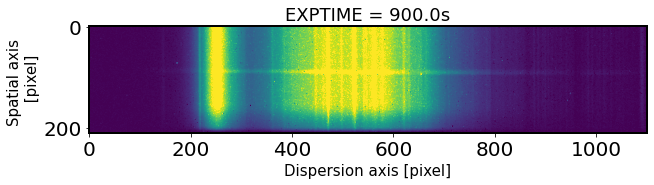

In [138]:
# Bring the sample image

OBJECTNAME = SUBPATH/'pSN2022xkq-0005.fits'
# OBJECTNAME = SUBPATH/'pHR9087-0001.fits'
hdul = fits.open(OBJECTNAME)[0]
obj = hdul.data
header = hdul.header
EXPTIME = header['EXPTIME']
fig,ax = plt.subplots(1,1,figsize=(10,15))
ax.imshow(obj,vmin=0,vmax=3000)
ax.set_title('EXPTIME = {0}s'.format(EXPTIME))
ax.set_xlabel('Dispersion axis [pixel]')
ax.set_ylabel('Spatial axis \n [pixel]')


[[94]]


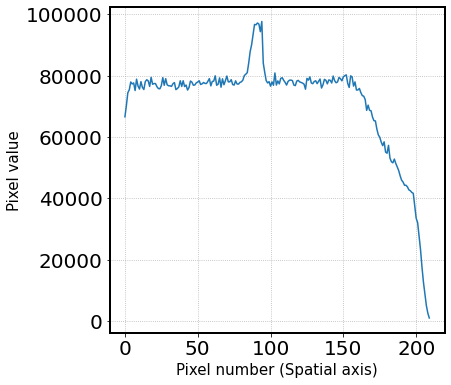

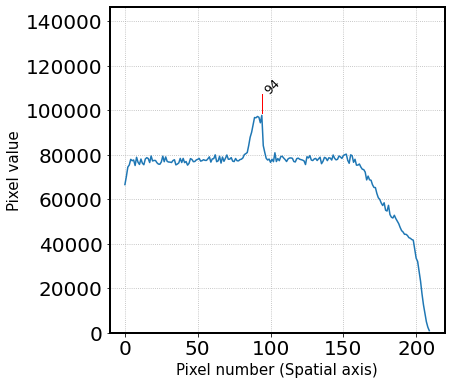

Pixel coordinatate in spatial direction = 94


In [139]:
# Let's find the peak along the spatial axis

# Plot the spectrum along the spatial direction
source_range_min = 650
source_range_max = 700
apall_1 = np.sum(obj[:,source_range_min:source_range_max],axis=1)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(apall_1)
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.grid(ls=':')

# Find the peak

peak_pix = peak_local_max(apall_1, num_peaks=1,
                          min_distance = 30,
                          threshold_abs=np.median(apall_1))
print(peak_pix)

fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.arange(0, len(apall_1))
ax.plot(x,apall_1)
ax.set_xlabel('Spatial axis')

peak = []
for i in peak_pix:
    ax.plot((i, i), 
            (apall_1[i]+0.01*max(apall_1),apall_1[i]+0.1*max(apall_1)),
            color='r', ls='-', lw=1)
    ax.annotate(i[0], (i[0], apall_1[i][0]+0.1*max(apall_1)),
            fontsize='small', rotation=45)
    peak.append(apall_1[i])

order = peak.index(max(peak))
pix_peak = peak_pix[order] 

ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(0, apall_1[pix_peak]*1.5)

plt.show()

print(f'Pixel coordinatate in spatial direction = {pix_peak[0]}')

Peak pixel is 94 pix
ap_sky =  [ 44  74 114 144]
x_sky =  [ 44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143]
sky_val =  [76094. 78226. 77864. 76858. 76934. 77627. 77901. 78316. 77100. 77317.
 77748. 77445. 77420. 78166. 79021. 76651. 78096. 78202. 79926. 76835.
 77203. 79252. 76216. 78947. 77017. 78335. 79849. 77945. 77982. 78666.
 78532. 78368. 76919. 76731. 78213. 78443. 77951. 77751. 77556. 77204.
 75560. 79083. 78520. 79582. 77577. 77365. 78084. 78311. 77375. 78167.
 78866. 75945. 77000. 78774. 78470. 77309. 78582. 78457. 77589. 79847.]
Sky area is from 44 pix ~ 74 pix and 114 pix ~ 144 pix


(0.0, 195304.0)

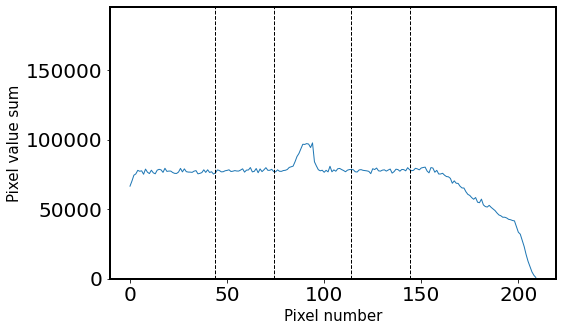

In [140]:
# select the sky area
peak = pix_peak[0] # center
print('Peak pixel is {0} pix'.format(pix_peak[0]))

lower_limit = 20
upper_limit = 50
ap_sky = np.array([peak-upper_limit,peak-lower_limit,
                   peak+lower_limit,peak+upper_limit]) # setting the sky area
print('ap_sky = ',ap_sky)

x_sky = np.hstack((np.arange(ap_sky[0], ap_sky[1]), 
                   np.arange(ap_sky[2], ap_sky[3])))  # bring the 
print('x_sky = ',x_sky)

sky_val = np.hstack((apall_1[ap_sky[0]:ap_sky[1]], 
                     apall_1[ap_sky[2]:ap_sky[3]]))
print('sky_val = ',sky_val)

print('Sky area is from {0} pix ~ {1} pix \
and {2} pix ~ {3} pix'.format(ap_sky[0], ap_sky[1], ap_sky[2], ap_sky[3]))


#Plot the sky area
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.plot(x, apall_1, lw=1)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]

ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(0,apall_1[pix_peak]*2)

Text(0.5, 1.0, 'Skyfit: Chebyshev order 3 (3.0-sigma 5-iters)')

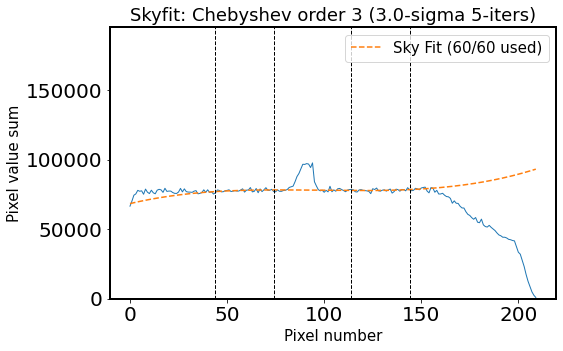

In [141]:
# Sigma clipping
Sigma = 3
clip_mask = sigma_clip(sky_val,
                       sigma= Sigma,
                       maxiters= 5).mask

# Fit the sky
ORDER_APSKY = 3
coeff_apsky, fitfull = chebfit(x_sky[~clip_mask], 
                               sky_val[~clip_mask],
                               deg=ORDER_APSKY,
                               full=True)
sky_fit = chebval(x, coeff_apsky) 

# Calculate the RMS of Fit
residual = fitfull[0][0] 
fitRMS = np.sqrt(residual/len(x_sky[~clip_mask]))


n_sky = len(x_sky)
n_rej = np.count_nonzero(clip_mask)

# Plot the sky area & fitted sky
fig,ax = plt.subplots(1,1,figsize=(8, 5))

ax.plot(x, apall_1, lw=1)
ax.plot(x, sky_fit, ls='--',
        label='Sky Fit ({:d}/{:d} used)'.format(n_sky - n_rej, n_sky))
ax.plot(x_sky[clip_mask], sky_val[clip_mask], marker='x', ls='', ms=10)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]


title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(0,apall_1[pix_peak]*2)
ax.legend()
ax.set_title(title_str.format('Chebyshev', ORDER_APSKY,
                              Sigma, 5))

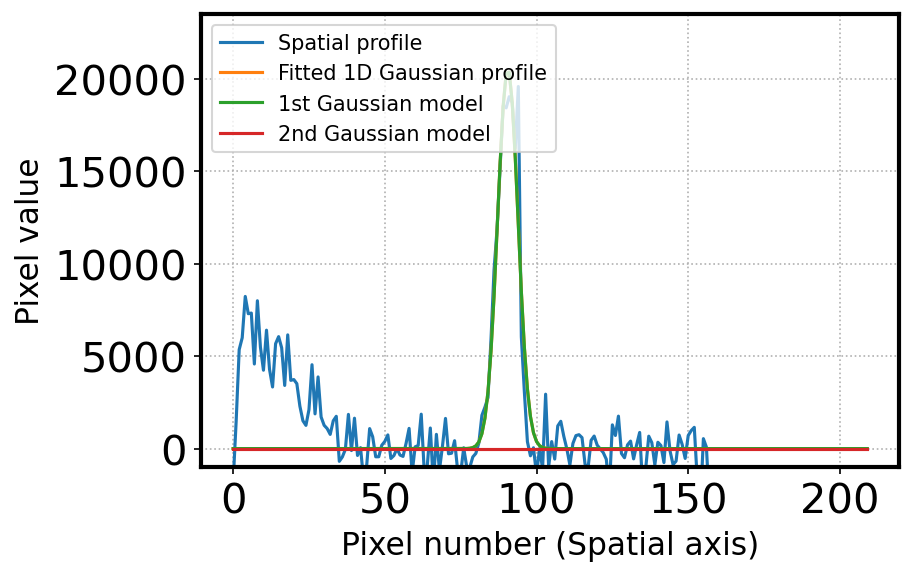

center pixel: 90.54155602082226


In [146]:
# Finding the peak center by fitting the gaussian 1D function again

sub_apall_1 = apall_1 - sky_fit #Profile - sky

OUTPIX = 40 # number of pixels to rule out outermost area in spacial direction
xx = x[OUTPIX:-OUTPIX]
yy = sub_apall_1[OUTPIX:-OUTPIX]

# Sometimes, due to the manual guiding, we might need double components for the modeling.
# Below is just a sketch of modeling with double component fitting.
# But we will use single gaussian modeling for the aperture tracing.
# double gaussian model
g1 = Gaussian1D(amplitude=sub_apall_1[pix_peak], 
                     mean=pix_peak,
                     stddev=15*gaussian_fwhm_to_sigma)

g2 = Gaussian1D(amplitude=sub_apall_1[pix_peak], 
                     mean=pix_peak+20,
                     stddev=15*gaussian_fwhm_to_sigma)

g_init = g1 + g2

fitter = LevMarLSQFitter()
fitted = fitter(g_init, xx, yy)

params = [[fitted[i].amplitude.value, fitted[i].mean.value, fitted[i].stddev.value] for i in range(2)]
# params[0] is list containing parameters for 1st component.
# params[1] is for 2nd.

fig = plt.figure(dpi =150)
ax = fig.add_subplot(111)
x = np.arange(0, len(apall_1))
ax.plot(x, sub_apall_1, label='Spatial profile')

gg1 = Gaussian1D(*params[0]) # 1st comp.
gg2 = Gaussian1D(*params[1]) # 2nd comp.
ggg = gg1 + gg2

ax.plot(x, ggg(x), label='Fitted 1D Gaussian profile')
ax.plot(x, gg1(x), label='1st Gaussian model')
ax.plot(x, gg2(x), label='2nd Gaussian model')
ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(-1000, sub_apall_1[pix_peak]*1.2)
ax.legend(loc=2,fontsize=10)
plt.show()

center_pix = params[0][1] # I just picked the narrower and higher peak
print('center pixel:', center_pix)

In [147]:
# Trace the aperture (peak) along the wavelength.
# Repeat the above process for all wavelength bands.
# This process is called "aperture tracing".
aptrace = []
aptrace_fwhm = []
STEP_AP = 10  
N_AP = len(obj[0])//STEP_AP
FWHM_AP = 10#round(2.35*params[0][2])
peak = center_pix
for i in range(N_AP - 1):
    lower_cut, upper_cut = i*STEP_AP, (i+1)*STEP_AP
    apall_i = np.sum(obj[:, lower_cut:upper_cut], axis=1)
    sky_val = np.hstack( (apall_i[ap_sky[0]:ap_sky[1]], 
                          apall_i[ap_sky[2]:ap_sky[3]]) )
    clip_mask = sigma_clip(sky_val,
                           sigma=3,
                           maxiters=5).mask
    coeff, fitfull = chebfit(x_sky[~clip_mask], 
                             sky_val[~clip_mask],
                             deg=ORDER_APSKY,
                             full=True)
    apall_i -= chebval(x,coeff)  # Object profile - the fitted sky
    
    search_min = int(peak - 3*FWHM_AP)
    search_max = int(peak + 3*FWHM_AP)
    cropped = apall_i[search_min:search_max]
    x_cropped = np.arange(len(cropped))
    
    peak_pix = peak_local_max(cropped,
                              min_distance=FWHM_AP,
                              num_peaks=1)
 
    if len(peak_pix)==0: # return NaN (Not a Number) if there is no peak found. 
        aptrace.append(np.nan)
        aptrace_fwhm.append(0)
        continue
        
    else:
        peak_pix = peak_pix[0][0]   
        g_init = Gaussian1D(amplitude=cropped[peak_pix], # Gaussian fitting to find centers
                            mean=peak_pix,
                            stddev=FWHM_AP * gaussian_fwhm_to_sigma,
                            bounds={'amplitude':(0, 2*cropped[peak_pix]) ,
                                    'mean':(peak_pix-3*FWHM_AP, peak_pix+3*FWHM_AP),
                                    'stddev':(0.00001, FWHM_AP*gaussian_fwhm_to_sigma)})
        fitted = fitter(g_init, x_cropped, cropped)
        center_pix_new = fitted.mean.value + search_min
        aptrace_fwhm.append(fitted.fwhm)
        aptrace.append(center_pix_new)  
        
aptrace = np.array(aptrace)
aptrace_fwhm = np.array(aptrace_fwhm)          

Text(0, 0.5, 'Spatial axis')

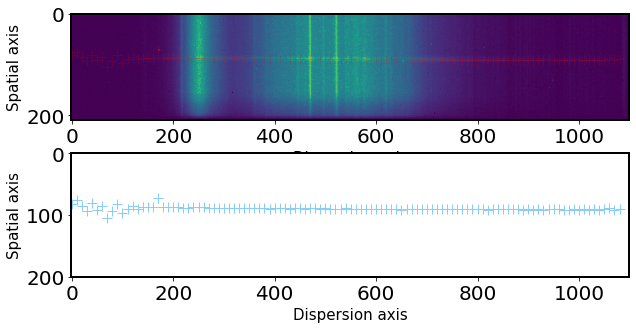

In [148]:
# Plot the center of profile peak
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].imshow(obj,vmin=0,vmax=6000)
ax[0].set_xlabel('Dispersion axis',fontsize=15)
ax[0].set_ylabel('Spatial axis',fontsize=15)
ax[0].plot(np.arange(len(aptrace))*10, aptrace,ls='', marker='+', ms=10,color='r', alpha =0.15)
xlim = ax[0].get_xlim()

ax[1].plot(np.arange(len(aptrace))*10, aptrace,ls='', marker='+', ms=10,color='lightskyblue')
ax[1].set_xlim(xlim)
ax[1].set_ylim(200,0) # you can see the jiggly-wiggly shape when you zoom in
ax[1].set_xlabel('Dispersion axis',fontsize=15)
ax[1].set_ylabel('Spatial axis',fontsize=15)
        

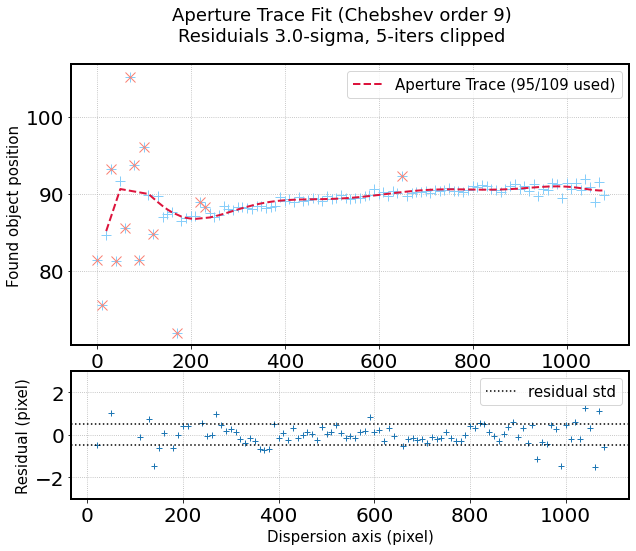

In [149]:
# Fitting the peak with Chebyshev function

ORDER_APTRACE = 9
SIGMA_APTRACE = 3
ITERS_APTRACE = 5 # when sigma clipping

# Fitting the line
x_aptrace = np.arange(N_AP-1) * STEP_AP
coeff_aptrace = chebfit(x_aptrace, aptrace, deg=ORDER_APTRACE)

# Sigma clipping
resid_mask = sigma_clip(aptrace - chebval(x_aptrace, coeff_aptrace), 
                        sigma=SIGMA_APTRACE, maxiters=ITERS_APTRACE).mask

# Fitting the peak again after sigma clipping
x_aptrace_fin = x_aptrace[~resid_mask]
aptrace_fin = aptrace[~resid_mask]
coeff_aptrace_fin = chebfit(x_aptrace_fin, aptrace_fin, deg=ORDER_APTRACE)   

fit_aptrace_fin   = chebval(x_aptrace_fin, coeff_aptrace_fin)
resid_aptrace_fin = aptrace_fin - fit_aptrace_fin
del_aptrace = ~np.in1d(x_aptrace, x_aptrace_fin) # deleted points #x_aptrace에서 x_aptrace_fin이 없으면 True
'''
test = np.array([0, 1, 2, 5, 0])
states = [0, 2]
mask = np.in1d(test, states)
mask
array([ True, False,  True, False,  True])
'''


# Plot the Fitted line & residual
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2])
ax2 = plt.subplot(gs[2])

ax1.plot(x_aptrace, aptrace, ls='', marker='+', ms=10,color='lightskyblue')
ax1.plot(x_aptrace_fin, fit_aptrace_fin, ls='--',color='crimson',zorder=10,lw=2,
         label="Aperture Trace ({:d}/{:d} used)".format(len(aptrace_fin), N_AP-1))
ax1.plot(x_aptrace[del_aptrace], aptrace[del_aptrace], ls='', marker='x',color='salmon', ms=10)
ax1.set_ylabel('Found object position')
ax1.grid(ls=':')
ax1.legend()


ax2.plot(x_aptrace_fin, resid_aptrace_fin, ls='', marker='+')
ax2.axhline(+np.std(resid_aptrace_fin, ddof=1), ls=':', color='k')
ax2.axhline(-np.std(resid_aptrace_fin, ddof=1), ls=':', color='k', 
            label='residual std')


ax2.set_ylabel('Residual (pixel)')
ax2.set_xlabel('Dispersion axis (pixel)')

ax2.grid(ls=':')
ax2.set_ylim(-3, 3)
ax2.legend()

#Set plot title
title_str = ('Aperture Trace Fit ({:s} order {:d})\n'
            + 'Residuials {:.1f}-sigma, {:d}-iters clipped')
plt.suptitle(title_str.format('Chebshev', ORDER_APTRACE,
                              SIGMA_APTRACE, ITERS_APTRACE))
plt.show()


In [150]:
# Aperture sum

apsum_sigma_lower = 3 # [Sigma]
apsum_sigma_upper = 3
ap_fwhm = np.median(aptrace_fwhm[~resid_mask]) # [pix]
ap_sigma = ap_fwhm *gaussian_fwhm_to_sigma # [pixel/sigma]
x_ap = np.arange(len(obj[0])) # Pixel along the dispersion axis
y_ap = chebval(x_ap, coeff_aptrace_fin) # Center of peak for each line
ap_sky_offset = ap_sky - pix_peak # location of sky area regarding of peak point


# Extract the spectrum along the dispersion axis
ap_summed  = []
ap_sig = []

for i in range(len(obj[0])):
    cut_i = obj[:,i] # Cut spatial direction
    peak_i = y_ap[i]
    ap_sky_i = int(peak_i) + ap_sky_offset
    
    # aperture size = apsum_sigma_lower * ap_sigma
    x_obj_lower = int(np.around(peak_i - apsum_sigma_lower * ap_sigma)) 
    x_obj_upper = int(np.around(peak_i + apsum_sigma_upper * ap_sigma))         
    x_obj = np.arange(x_obj_lower, x_obj_upper)
    obj_i = cut_i[x_obj_lower:x_obj_upper]
    


    # Fitting Sky value
    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
                        np.arange(ap_sky_i[2], ap_sky_i[3])) )
    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
                          cut_i[ap_sky_i[2]:ap_sky_i[3]]) )
    clip_mask = sigma_clip(sky_val, sigma=Sigma,
                           maxiters=5).mask
    coeff = chebfit(x_sky[~clip_mask],
                    sky_val[~clip_mask],
                    deg=ORDER_APSKY)

    # Subtract the sky
    sub_obj_i = obj_i - chebval(x_obj, coeff) # obj - lsky  subtraction

    
    # Calculate error
    sig_i = RN **2 + sub_obj_i + chebval(x_obj,coeff)
    # RN**2 + flux_i + sky value 
    
    ap_summed.append(np.sum(sub_obj_i)) 
    ap_sig.append(np.sqrt(np.sum(sig_i)))
    
ap_summed = np.array(ap_summed) / EXPTIME    
ap_std = np.array(ap_sig) / EXPTIME    

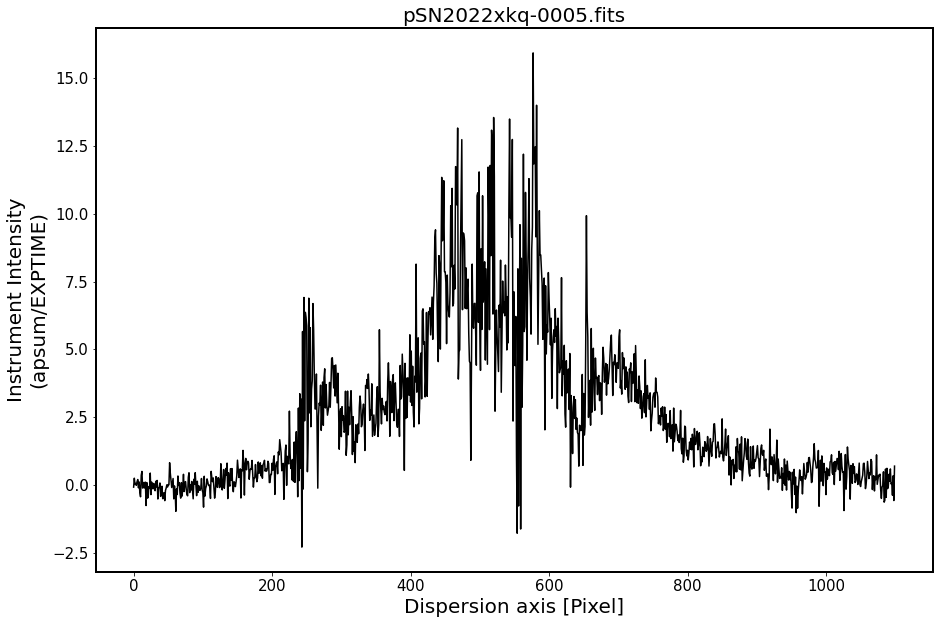

In [151]:
# Plot the spectrum 

x_pix = np.arange(len(obj[0]))

fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(x_pix,ap_summed,color='k',alpha=1)


FILENAME = OBJECTNAME.name
ax.set_title(FILENAME,fontsize=20)
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
ax.set_xlabel(r'Dispersion axis [Pixel]',fontsize=20) 
ax.tick_params(labelsize=15)
plt.show()

spec_before_wfcali = Table([x_pix, ap_summed, ap_std],
                          names=['x_pix', 'ap_summed', 'ap_std'])


spec_before_wfcali.write(SUBPATH/(OBJECTNAME.stem+'_inst_spec.csv'),
                        overwrite=True, format='csv')

## Aperture tracing & aperture sum for standard star

Text(0, 0.5, 'Spatial axis \n [pixel]')

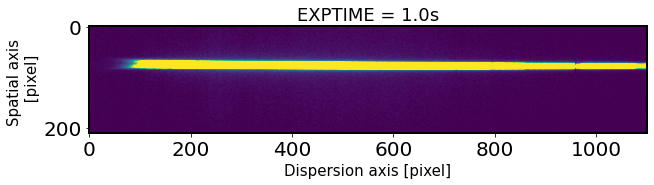

In [443]:
# Bring the sample image

OBJECTNAME = SUBPATH/'pHR153-0009.fits'
hdul = fits.open(OBJECTNAME)[0]
obj = hdul.data
header = hdul.header
EXPTIME = header['EXPTIME']
fig,ax = plt.subplots(1,1,figsize=(10,15))
ax.imshow(obj,vmin=0,vmax=300)
ax.set_title('EXPTIME = {0}s'.format(EXPTIME))
ax.set_xlabel('Dispersion axis [pixel]')
ax.set_ylabel('Spatial axis \n [pixel]')


[[78]]


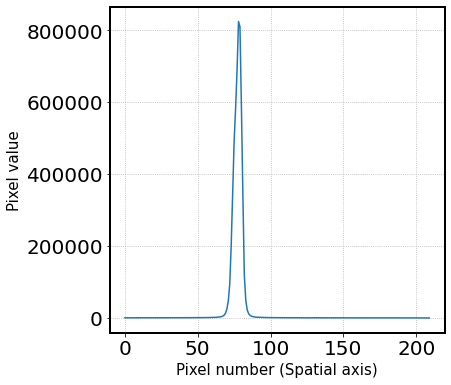

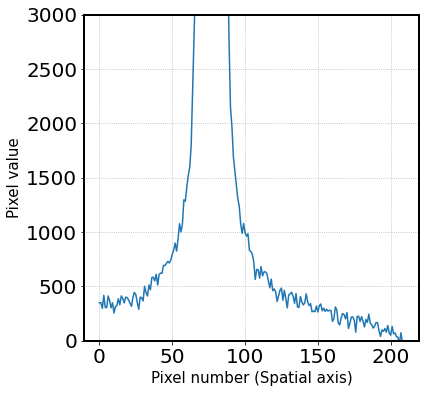

Pixel coordinatate in spatial direction = 78


In [444]:
# Let's find the peak along the spatial axis

# Plot the spectrum along the spatial direction
star_range_min = 450
star_range_max = 500
apall_1 = np.sum(obj[:,star_range_min:star_range_max],axis=1)

fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(apall_1)
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.grid(ls=':')

# Find the peak

peak_pix = peak_local_max(apall_1, num_peaks=10,
                          min_distance = 30,
                          threshold_abs=np.median(apall_1))
print(peak_pix)

fig,ax = plt.subplots(1,1,figsize=(6,6))
x = np.arange(0, len(apall_1))
ax.plot(x,apall_1)
ax.set_xlabel('Spatial axis')

peak = []
for i in peak_pix:
    ax.plot((i, i), 
            (apall_1[i]+0.01*max(apall_1),apall_1[i]+0.1*max(apall_1)),
            color='r', ls='-', lw=1)
    ax.annotate(i[0], (i[0], apall_1[i][0]+0.1*max(apall_1)),
            fontsize='small', rotation=45)
    peak.append(apall_1[i])

order = peak.index(max(peak))
pix_peak = peak_pix[order] 

ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(0, 3000)#apall_1[pix_peak]*1.5)

plt.show()

print(f'Pixel coordinatate in spatial direction = {pix_peak[0]}')

Peak pixel is 78 pix
ap_sky =  [ 28  48 108 128]
x_sky =  [ 28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127]
sky_val =  [402. 396. 367. 501. 443. 412. 513. 469. 582. 585. 551. 612. 513. 610.
 623. 621. 694. 692. 712. 730. 657. 653. 577. 683. 598. 633. 635. 618.
 551. 487. 568. 461. 477. 450. 361. 413. 464. 485. 373. 464.]
Sky area is from 28 pix ~ 48 pix and 108 pix ~ 128 pix


(-100000.0, 1649988.0)

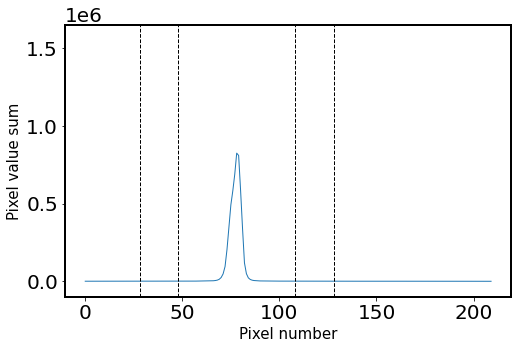

In [445]:
# select the sky area
peak = pix_peak[0] # center
print('Peak pixel is {0} pix'.format(pix_peak[0]))

lower_limit = 30
upper_limit = 50
ap_sky = np.array([peak-upper_limit,peak-lower_limit,
                   peak+lower_limit,peak+upper_limit]) # setting the sky area
print('ap_sky = ',ap_sky)

x_sky = np.hstack((np.arange(ap_sky[0], ap_sky[1]), 
                   np.arange(ap_sky[2], ap_sky[3])))  # bring the 
print('x_sky = ',x_sky)

sky_val = np.hstack((apall_1[ap_sky[0]:ap_sky[1]], 
                     apall_1[ap_sky[2]:ap_sky[3]]))
print('sky_val = ',sky_val)

print('Sky area is from {0} pix ~ {1} pix \
and {2} pix ~ {3} pix'.format(ap_sky[0], ap_sky[1], ap_sky[2], ap_sky[3]))


#Plot the sky area
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.plot(x, apall_1, lw=1)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]

ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(-100000,apall_1[pix_peak]*2)

Text(0.5, 1.0, 'Skyfit: Chebyshev order 3 (3.0-sigma 5-iters)')

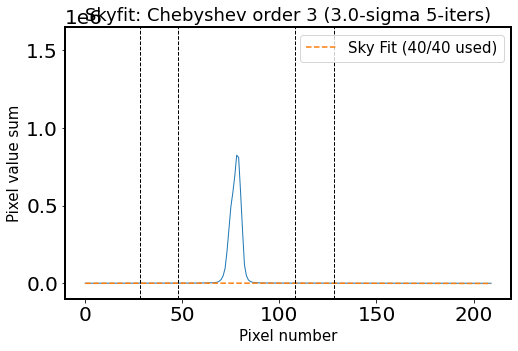

In [446]:
# Sigma clipping
Sigma = 3
clip_mask = sigma_clip(sky_val,
                       sigma=Sigma,
                       maxiters=5).mask

# Fit the sky
ORDER_APSKY = 3
coeff_apsky, fitfull = chebfit(x_sky[~clip_mask], 
                               sky_val[~clip_mask],
                               deg=ORDER_APSKY,
                               full=True)
sky_fit = chebval(x, coeff_apsky) 

# Calculate the RMS of Fit
residual = fitfull[0][0] 
fitRMS = np.sqrt(residual/len(x_sky[~clip_mask]))


n_sky = len(x_sky)
n_rej = np.count_nonzero(clip_mask)

# Plot the sky area & fitted sky
fig, ax = plt.subplots(1,1,figsize=(8, 5))

ax.plot(x, apall_1, lw=1)
ax.plot(x, sky_fit, ls='--',
        label='Sky Fit ({:d}/{:d} used)'.format(n_sky - n_rej, n_sky))
ax.plot(x_sky[clip_mask], sky_val[clip_mask], marker='x', ls='', ms=10)
[ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]


title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_ylim(-100000,apall_1[pix_peak]*2)
ax.legend()
ax.set_title(title_str.format('Chebyshev', ORDER_APSKY,
                              Sigma, 5))

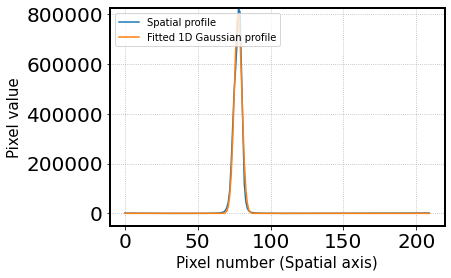

center pixel: Parameter('mean', value=77.70146655446975)


In [447]:
# Finding the peak center by fitting the gaussian 1D function again

sub_apall_1 = apall_1 - sky_fit #Profile - sky

OUTPIX = 15 # number of pixels to rule out outermost area in spacial direction
xx = x[OUTPIX:-OUTPIX]
yy = sub_apall_1[OUTPIX:-OUTPIX]

# single gaussian model
g_init = Gaussian1D(amplitude=sub_apall_1[pix_peak], 
                    mean=pix_peak,
                    stddev=15*gaussian_fwhm_to_sigma)

fitter = LevMarLSQFitter()
fitted = fitter(g_init, xx, yy)

fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(0, len(apall_1))
ax.plot(x, sub_apall_1, label='Spatial profile')

ax.plot(x, fitted(x), label='Fitted 1D Gaussian profile')
ax.grid(ls=':')
ax.set_xlabel('Pixel number (Spatial axis)')
ax.set_ylabel('Pixel value')
ax.set_ylim(-50000, sub_apall_1[pix_peak])
ax.legend(loc=2,fontsize=10)
plt.show()

center_pix = fitted.mean # I just picked the narrower and higher peak
print('center pixel:', center_pix)

In [448]:
# Trace the aperture (peak) along the wavelength.
# Repeat the above process for all wavelength bands.
# This process is called "aperture tracing".
aptrace = []
aptrace_fwhm = []
STEP_AP = 10  
N_AP = len(obj[0])//STEP_AP
FWHM_AP = 15
peak = center_pix
for i in range(N_AP - 1):
    lower_cut, upper_cut = i*STEP_AP, (i+1)*STEP_AP
    apall_i = np.sum(obj[:, lower_cut:upper_cut], axis=1)
    sky_val = np.hstack( (apall_i[ap_sky[0]:ap_sky[1]], 
                          apall_i[ap_sky[2]:ap_sky[3]]) )
    clip_mask = sigma_clip(sky_val,
                           sigma=3,
                           maxiters=5).mask
    coeff, fitfull = chebfit(x_sky[~clip_mask], 
                             sky_val[~clip_mask],
                             deg=ORDER_APSKY,
                             full=True)
    apall_i -= chebval(x,coeff)  # Object profile - the fitted sky
    
    search_min = int(peak - 3*FWHM_AP)
    search_max = int(peak + 3*FWHM_AP)
    cropped = apall_i[search_min:search_max]
    x_cropped = np.arange(len(cropped))
    
    peak_pix = peak_local_max(cropped,
                              min_distance=FWHM_AP,
                              num_peaks=1)
 
    if len(peak_pix)==0: # return NaN (Not a Number) if there is no peak found. 
        aptrace.append(np.nan)
        aptrace_fwhm.append(0)
        print(lower_cut, FWHM_AP)
        continue
        
    else:
        peak_pix = peak_pix[0][0]   
        g_init = Gaussian1D(amplitude=cropped[peak_pix], # Gaussian fitting to find centers
                            mean=peak_pix,
                            stddev=FWHM_AP * gaussian_fwhm_to_sigma,
                            bounds={'amplitude':(0, 2*cropped[peak_pix]) ,
                                    'mean':(peak_pix-3*FWHM_AP, peak_pix+3*FWHM_AP),
                                    'stddev':(0.00001, FWHM_AP*gaussian_fwhm_to_sigma)})
        fitted = fitter(g_init, x_cropped, cropped)
        center_pix_new = fitted.mean.value + search_min
        aptrace_fwhm.append(fitted.fwhm)
        aptrace.append(center_pix_new)  
        
aptrace = np.array(aptrace)
aptrace_fwhm = np.array(aptrace_fwhm)          

Text(0, 0.5, 'Spatial axis')

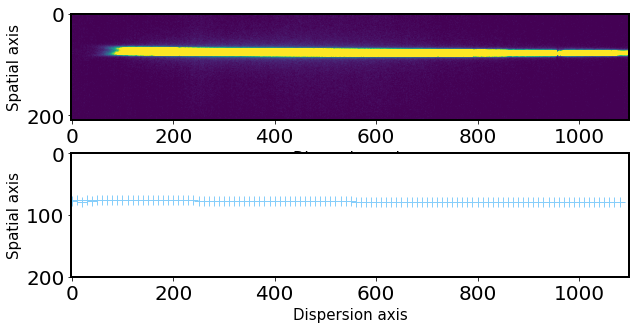

In [449]:
# Plot the center of profile peak
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].imshow(obj,vmin=0,vmax=300)
ax[0].set_xlabel('Dispersion axis',fontsize=15)
ax[0].set_ylabel('Spatial axis',fontsize=15)
xlim = ax[0].get_xlim()

ax[1].plot(np.arange(len(aptrace))*10, aptrace,ls='', marker='+', ms=10,color='lightskyblue')
ax[1].set_xlim(xlim)
ax[1].set_ylim(200,0)
ax[1].set_xlabel('Dispersion axis',fontsize=15)
ax[1].set_ylabel('Spatial axis',fontsize=15)
        

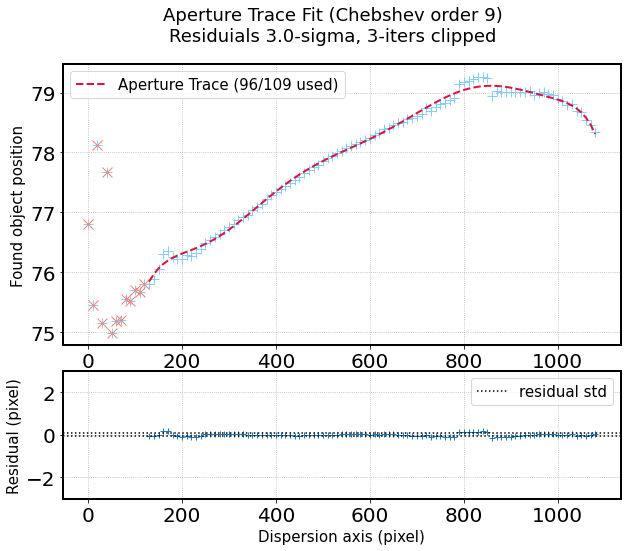

In [450]:
# Fitting the peak with Chebyshev function

ORDER_APTRACE = 9
SIGMA_APTRACE = 3
ITERS_APTRACE = 3 # when sigma clipping

# Fitting the line
x_aptrace = np.arange(N_AP-1) * STEP_AP
# - This is manual mask for region where the light from the source is too dim to trace.
custom_mask = x_aptrace > 350
coeff_aptrace = chebfit(x_aptrace[custom_mask], aptrace[custom_mask], deg=ORDER_APTRACE)

# Sigma clipping
resid_mask = sigma_clip(aptrace - chebval(x_aptrace, coeff_aptrace), 
                        sigma=SIGMA_APTRACE, maxiters=ITERS_APTRACE).mask

# Fitting the peak again after sigma clipping
x_aptrace_fin = x_aptrace[~resid_mask]
aptrace_fin = aptrace[~resid_mask]
coeff_aptrace_fin = chebfit(x_aptrace_fin, aptrace_fin, deg=ORDER_APTRACE)   

fit_aptrace_fin   = chebval(x_aptrace_fin, coeff_aptrace_fin)
resid_aptrace_fin = aptrace_fin - fit_aptrace_fin
del_aptrace = ~np.in1d(x_aptrace, x_aptrace_fin) # deleted points #x_aptrace에서 x_aptrace_fin이 없으면 True
'''
test = np.array([0, 1, 2, 5, 0])
states = [0, 2]
mask = np.in1d(test, states)
mask
array([ True, False,  True, False,  True])
'''


# Plot the Fitted line & residual
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2])
ax2 = plt.subplot(gs[2])

ax1.plot(x_aptrace, aptrace, ls='', marker='+', ms=10,color='lightskyblue')
ax1.plot(x_aptrace_fin, fit_aptrace_fin, ls='--',color='crimson',zorder=10,lw=2,
         label="Aperture Trace ({:d}/{:d} used)".format(len(aptrace_fin), N_AP-1))
ax1.plot(x_aptrace[del_aptrace], aptrace[del_aptrace], ls='', marker='x',color='salmon', ms=10)
ax1.set_ylabel('Found object position')
ax1.grid(ls=':')
ax1.legend()
xlim = ax1.get_xlim()

ax2.plot(x_aptrace_fin, resid_aptrace_fin, ls='', marker='+')
ax2.axhline(+np.std(resid_aptrace_fin, ddof=1), ls=':', color='k')
ax2.axhline(-np.std(resid_aptrace_fin, ddof=1), ls=':', color='k', 
            label='residual std')


ax2.set_ylabel('Residual (pixel)')
ax2.set_xlabel('Dispersion axis (pixel)')

ax2.grid(ls=':')
ax2.set_xlim(xlim)
ax2.set_ylim(-3, 3)
ax2.legend()

#Set plot title
title_str = ('Aperture Trace Fit ({:s} order {:d})\n'
            + 'Residuials {:.1f}-sigma, {:d}-iters clipped')
plt.suptitle(title_str.format('Chebshev', ORDER_APTRACE,
                              SIGMA_APTRACE, ITERS_APTRACE))
plt.show()


In [451]:
# Aperture sum

apsum_sigma_lower = 3 # [Sigma]
apsum_sigma_upper = 3
ap_fwhm = np.median(aptrace_fwhm[~resid_mask]) # [pix]
ap_sigma = ap_fwhm * gaussian_fwhm_to_sigma # [pixel/sigma]
x_ap = np.arange(len(obj[0])) # Pixel along the dispersion axis
y_ap = chebval(x_ap, coeff_aptrace_fin) # Center of peak for each line
ap_sky_offset = ap_sky - pix_peak # location of sky area regarding of peak point


# Extract the spectrum along the dispersion axis
ap_summed  = []
ap_sig = []

for i in range(len(obj[0])):
    cut_i = obj[:,i] # Cut spatial direction
    peak_i = y_ap[i]
    ap_sky_i = int(peak_i) + ap_sky_offset
    
    # aperture size = apsum_sigma_lower * ap_sigma
    x_obj_lower = int(np.around(peak_i - apsum_sigma_lower * ap_sigma)) 
    x_obj_upper = int(np.around(peak_i + apsum_sigma_upper * ap_sigma))         
    x_obj = np.arange(x_obj_lower, x_obj_upper)
    obj_i = cut_i[x_obj_lower:x_obj_upper]
    


    # Fitting Sky value
    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
                        np.arange(ap_sky_i[2], ap_sky_i[3])) )
    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
                          cut_i[ap_sky_i[2]:ap_sky_i[3]]) )
    clip_mask = sigma_clip(sky_val, sigma=Sigma,
                           maxiters=5).mask
    coeff = chebfit(x_sky[~clip_mask],
                    sky_val[~clip_mask],
                    deg=ORDER_APSKY)

    # Subtract the sky
    sub_obj_i = obj_i - chebval(x_obj, coeff) # obj - lsky  subtraction

    
    # Calculate error
    sig_i = RN **2 + sub_obj_i + chebval(x_obj,coeff)
    # RN**2 + flux_i + sky value 
    
    ap_summed.append(np.sum(sub_obj_i)) 
    ap_sig.append(np.sqrt(np.sum(sig_i)))
    
ap_summed = np.array(ap_summed) / EXPTIME    
ap_std = np.array(ap_sig) / EXPTIME    

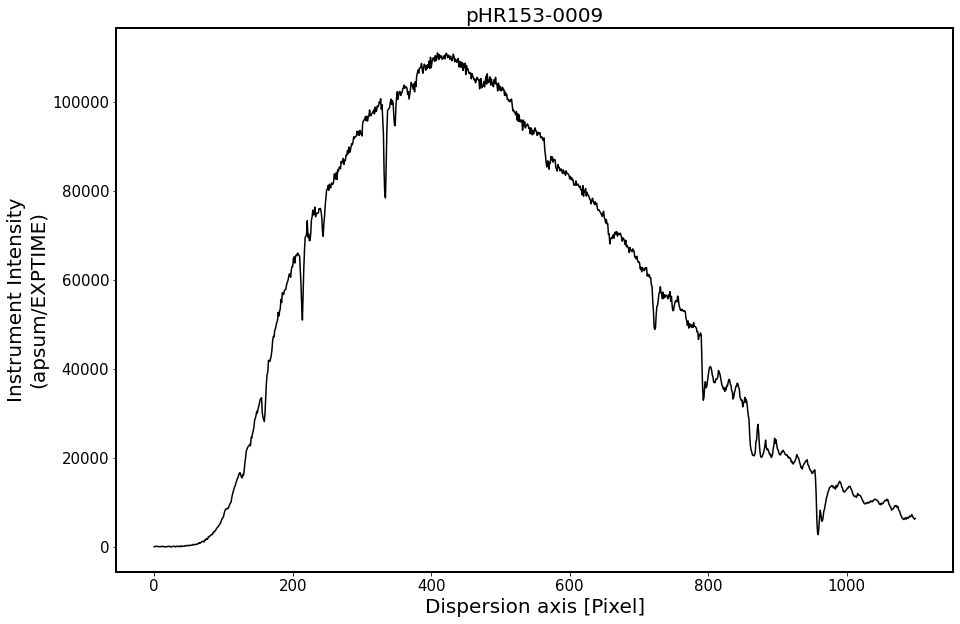

In [452]:
# Plot the spectrum 

x_pix = np.arange(len(obj[0]))

fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.plot(x_pix,ap_summed,color='k',alpha=1)


FILENAME = OBJECTNAME.stem
ax.set_title(FILENAME,fontsize=20)
ax.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)',fontsize=20)
ax.set_xlabel(r'Dispersion axis [Pixel]',fontsize=20) 
ax.tick_params(labelsize=15)
plt.show()

spec_before_wfcali = Table([x_pix, ap_summed, ap_std],
                          names=['x_pix', 'ap_summed', 'ap_std'])


spec_before_wfcali.write(SUBPATH/(OBJECTNAME.stem+'_inst_spec.csv'),
                         overwrite=True, format='csv')

# 2-2. Wavelength calibration

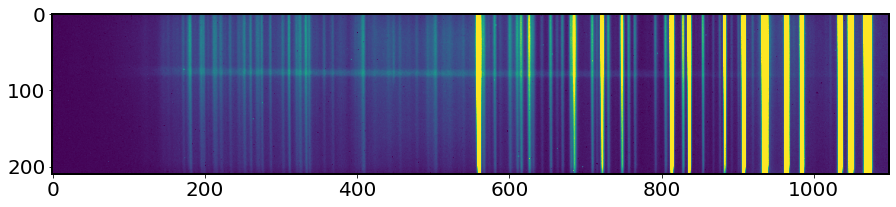

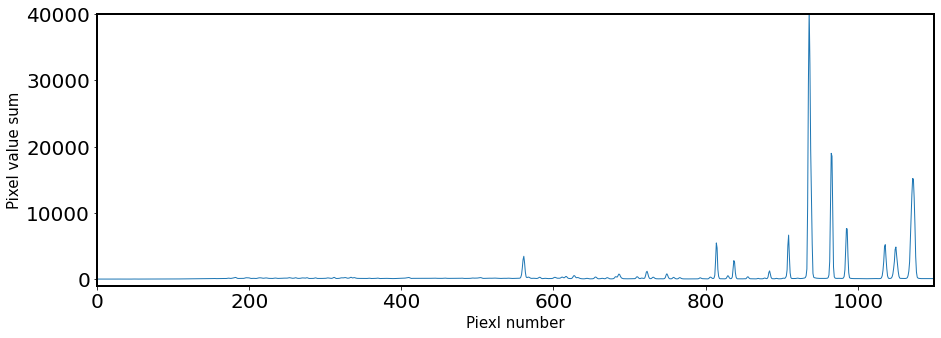

<Figure size 432x288 with 0 Axes>

In [328]:
# Bring the Master Comparison image
Master_comparison = SUBPATH/'pMaster_Neon.fits'
compimage = fits.open(Master_comparison)[0].data
identify = np.median(compimage[neon_range_min:neon_range_max,:],
                         axis=0)
fig,ax = fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.imshow(compimage, vmin=0, vmax=1000)

fig,ax = plt.subplots(1,1,figsize=(15,5))
x_identify = np.arange(0,len(identify))
ax.plot(x_identify,identify,lw=1)
ax.set_xlabel('Piexl number')
ax.set_ylabel('Pixel value sum')
ax.set_xlim(0,len(identify))
ax.set_ylim(-1000, 40000)
plt.show()
plt.tight_layout()


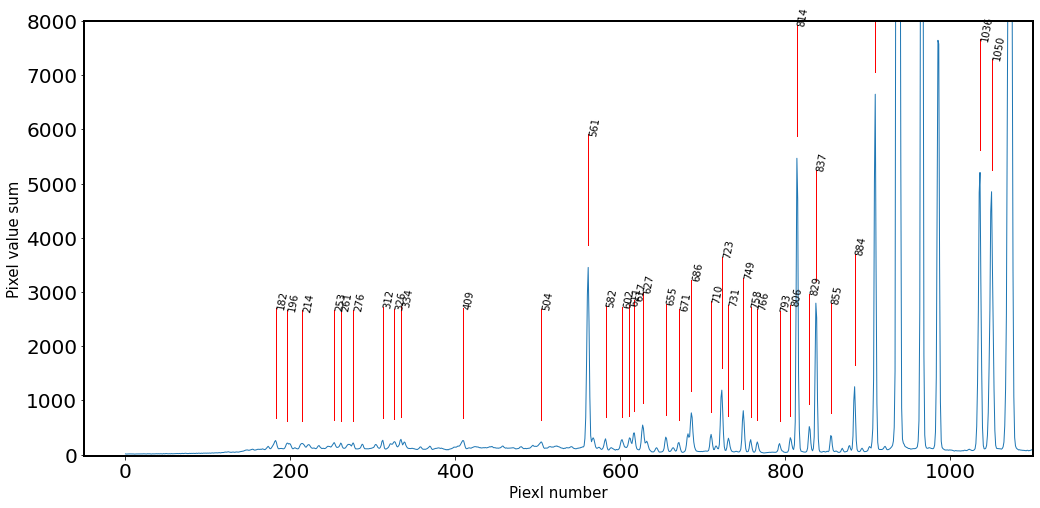

<Figure size 432x288 with 0 Axes>

In [337]:
# Find the local peak

peak_pix = peak_local_max(identify,
                          num_peaks = max(identify),
                          min_distance = 4,
                          threshold_abs= max(identify)*0.005)


fig,ax = plt.subplots(1,1,figsize=(17,8))
x_identify = np.arange(0,len(identify))
ax.plot(x_identify,identify,lw=1)
for i in peak_pix:
    ax.plot([i,i],
            [identify[i]+0.01*max(identify),identify[i]+0.06*max(identify)],
            color='r',lw=1)
    ax.annotate(i[0],(i,identify[i]+0.06*max(identify)),
                fontsize=10,
                rotation=80)

ax.set_xlabel('Piexl number')
ax.set_ylabel('Pixel value sum')
ax.set_xlim(-50,1100)
ax.set_ylim(-20,8000)
plt.show()
plt.tight_layout()


In [ ]:
pixel_init, wavelength = np.array([
                                    [171,  4200.674],
                                    [276,  4657.901],
                                    [301,  4764.865],
                                    # [739,  6677.282],
                                    [550,  5852.488], # Ne
                                    [571,  5944.834], # Ne
                                    [592,  6029.997], # Ne
                                    [617,  6143.063], # Ne
                                    [645,  6266.495], # Ne
                                    [676,  6402.246], # Ne
                                    [700,  6506.528], # Ne
                                    [739,  6678.276], # Ne
                                   # [756,  6752.834],

                                   ]).T

5588.84574069661


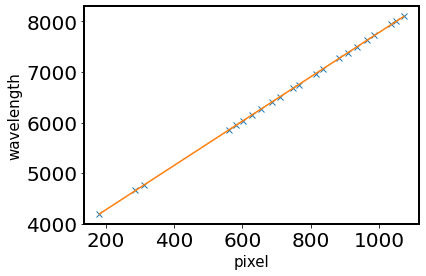

In [339]:
# Find the matching pair of wavelength and pixel
ID_init = dict(pixel_init = [182, 286, 312, 561, 582, 602, 627, 655, 686, 710, 749, 766, 814, 837, 884, 909, 936, 965, 985, 1036, 1050, 1072],
               wavelength = [4200.6874, 4657.901, 4764.865, 5852.488, 5944.834, 6029.997, 6143.063, 6266.495, 6402.246 ,6506.528, 6678.276, 6752.834, 6965.4, 7067.2, 7272.936, 7383.980, 7503.869, 7635.106, 7724.207, 7948.176, 8006.157, 8103.693])

ID_init = Table(ID_init)
plt.plot(ID_init['pixel_init'],ID_init['wavelength'],marker='x',ls='')

def linear(x,a,b):
    return a*x + b
popt,pcov = curve_fit(linear,ID_init['pixel_init'],ID_init['wavelength'])
plt.plot(ID_init['pixel_init'],linear(ID_init['pixel_init'],*popt))
plt.xlabel('pixel')
plt.ylabel('wavelength')
print(linear(500,*popt))


In [340]:
# Fit the each peak with Gaussian 1D function

peak_gauss = []
fitter = LevMarLSQFitter()
LINE_FITTER = LevMarLSQFitter()
FWHM_ID = 3
x_identify = np.arange(0,len(identify))

# Gaussian fitting for each peak (pixel)
for peak_pix in ID_init['pixel_init']:
    g_init = Gaussian1D(amplitude = identify[peak_pix],
                        mean = peak_pix,
                        stddev = FWHM_ID*gaussian_fwhm_to_sigma,
                        bounds={'amplitude':(0,2*identify[peak_pix]),
                                'mean':(peak_pix - FWHM_ID,peak_pix + FWHM_ID),
                                'stddev':(0,FWHM_ID)})
    fitted = LINE_FITTER(g_init,x_identify,identify) #Model, x, y
    peak_gauss.append(fitted.mean.value)
    print(peak_pix,'->',fitted.mean.value)
    
    
peak_gauss = Column(data=peak_gauss,
                        name='pixel_gauss',
                        dtype=float)    
peak_shift = Column(data=peak_gauss - ID_init['pixel_init'],
                    name='piexl_shift',
                    dtype=float) 
ID_init['pixel_gauss'] = peak_gauss
ID_init['pixel_shift'] = peak_gauss - ID_init['pixel_init']
ID_init.sort('wavelength')
ID_init.pprint()

182 -> 181.37522587001635
286 -> 286.21317932658536
312 -> 311.43652028456137
561 -> 560.7671811296193
582 -> 581.6413397442432
602 -> 602.6696308135929
627 -> 627.812787039712
655 -> 655.3102960045367
686 -> 685.5496309351199
710 -> 710.6182650535068
749 -> 748.9968920638865
766 -> 765.6951339915939
814 -> 814.2968959763366
837 -> 837.3291126524199
884 -> 883.8507242099114
909 -> 908.8089712906417
936 -> 936.2830816715424
965 -> 965.4476136491946
985 -> 985.38265911859
1036 -> 1035.6266446026673
1050 -> 1049.784886977986
1072 -> 1072.3021253847896
pixel_init wavelength    pixel_gauss          pixel_shift     
---------- ---------- ------------------ ---------------------
       182  4200.6874 181.37522587001635   -0.6247741299836491
       286   4657.901 286.21317932658536   0.21317932658536165
       312   4764.865 311.43652028456137    -0.563479715438632
       561   5852.488  560.7671811296193  -0.23281887038069726
       582   5944.834  581.6413397442432  -0.35866025575683125
    

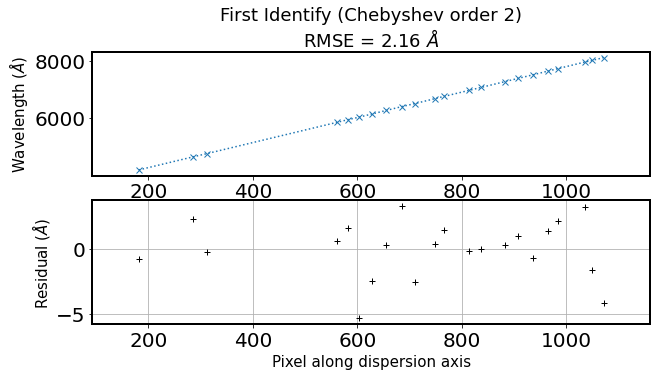

In [341]:
#Derive dispersion solution

ORDER_ID = 2 #Order of fitting function #보통 3 이하로 함. 기기의 사용파장대가 넓으면 4를 사용할때도 있음. 
coeff_ID, fitfull = chebfit(ID_init['pixel_gauss'],
                           ID_init['wavelength'],
                           deg=ORDER_ID,
                           full=True)  #Derive the dispersion solution

fitRMS = np.sqrt(fitfull[0][0]/len(ID_init))
rough_error = ((max(ID_init['wavelength'])-min(ID_init['wavelength']))
               /(max(ID_init['pixel_gauss'])-min(ID_init['pixel_gauss'])))/2
residual = (ID_init['wavelength'] #wavelength from reference
            -chebval(ID_init['pixel_gauss'],coeff_ID)) #wavelength derived from fitting
res_range = np.max(np.abs(residual))

fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(ID_init['pixel_gauss'],
         ID_init['wavelength'],
         ls = ':',marker='x')
ax[1].plot(ID_init['pixel_gauss'],
          residual,
          ls='',marker='+',
          color='k')
max_ID_init = max(ID_init['pixel_gauss'])
min_ID_init = min(ID_init['pixel_gauss'])
fig_xspan = max_ID_init - min_ID_init
fig_xlim = np.array([min_ID_init, max_ID_init]) + np.array([-1,1])*fig_xspan*0.1
ax[1].set_xlim(fig_xlim)
ax[0].set_xlim(fig_xlim)
ax[0].set_ylabel(r'Wavelength ($\AA$)')
ax[1].set_ylabel(r'Residual ($\AA$)')
ax[1].set_xlabel('Pixel along dispersion axis')
ax[0].set_title('First Identify (Chebyshev order {:d})\n'.format(ORDER_ID) 
              + r'RMSE = {:.2f} $\AA$'.format(fitRMS))
ax[1].grid()
plt.show()

In [342]:
# REIDENTIFY 

STEP_AP = 10 #Step size in pixel (dispersion direction)
STEP_REID = 10 #Step size in pixel (spatial direction)
N_SPATIAL,N_WAVELEN = np.shape(compimage) #(220, 2048)
N_REID = N_SPATIAL//STEP_REID #Spatial direction 
N_AP = N_WAVELEN//STEP_AP #Dispersion direction
TOL_REID = 5 # tolerence to lose a line in pixels

ORDER_WAVELEN_REID = 3 
ORDER_SPATIAL_REID = 3

line_REID = np.zeros((N_REID-1,len(ID_init))) #Make the empty array (height, width)
spatialcoord = np.arange(0,(N_REID-1)*STEP_REID,STEP_REID) + STEP_REID/2
# spatialcoord = array([  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
#       115., 125., 135., 145., 155., 165., 175., 185., 195., 205.])




#Repeat we did above along the spatial direction
for i in range(0,N_REID-1): 
    lower_cut = i*STEP_REID
    upper_cut = (i+1)*STEP_REID
    reidentify_i = np.sum(compimage[lower_cut:upper_cut,:],axis=0)

    peak_gauss_REID = [] 
    
    for peak_pix_init in ID_init['pixel_gauss']:
        search_min = int(np.around(peak_pix_init - TOL_REID))
        search_max = int(np.around(peak_pix_init + TOL_REID))
        cropped = reidentify_i[search_min:search_max]
        x_cropped = np.arange(len(cropped)) + search_min

        #Fitting the initial gauss peak by usijng Gausian1D
        Amplitude_init = np.max(cropped)
        mean_init = peak_pix_init
        stddev_init = 5*gaussian_fwhm_to_sigma
        g_init = Gaussian1D(amplitude = Amplitude_init,
                           mean = mean_init,
                           stddev = stddev_init,
                           bounds={'amplitude':(0, 2*np.max(cropped)) ,
                                 'stddev':(0, TOL_REID)})
        g_fit = fitter(g_init,x_cropped,cropped)
        fit_center = g_fit.mean.value    
        if abs(fit_center - peak_pix_init) > TOL_REID: #스펙트럼 끝에서는 잘 안 잡힐수있으니까
            peak_gauss_REID.append(np.nan)
            continue
        else:
            peak_gauss_REID.append(fit_center)
            
    peak_gauss_REID = np.array(peak_gauss_REID)  
    nonan_REID = np.isfinite(peak_gauss_REID)
    line_REID[i,:] = peak_gauss_REID  
    peak_gauss_REID_nonan = peak_gauss_REID[nonan_REID] 
    n_tot = len(peak_gauss_REID)
    n_found = np.count_nonzero(nonan_REID)
    coeff_REID1D, fitfull = chebfit(peak_gauss_REID_nonan,
                                    ID_init['wavelength'][nonan_REID], 
                                    deg=ORDER_WAVELEN_REID,
                                    full=True)
    fitRMS = np.sqrt(fitfull[0][0]/n_found)
    
points = np.vstack((line_REID.flatten(),
                    np.tile(spatialcoord, len(ID_init['pixel_init']))))
#np.tile(A,reps):Construct an array by repeating A the number of times given by reps.
# a = np.array([1, 2, 3])
# b = np.array([2, 3, 4])
# np.vstack((a,b)) = array([[1, 2, 3],[2, 3, 4]])
points = points.T # list of ()  
                   

values = np.tile(ID_init['wavelength'], N_REID - 1) #Wavelength corresponding to each point
values = np.array(values.tolist())  #
# errors = np.ones_like(values)


# #Fitting the wavelength along spatial direction and dispertion direction 
coeff_init = Chebyshev2D(x_degree=ORDER_WAVELEN_REID, y_degree=ORDER_SPATIAL_REID)
fit2D_REID = fitter(coeff_init, points[:, 0], points[:, 1], values) 
#Dispersion solution (both spatial & dispersion) #fitter(order,x,y,f(x,y))

Text(0.5, 0.98, 'Reidentify and Wavelength Map\nfunc=Chebyshev, order (wavelength, dispersion) = (3, 3)')

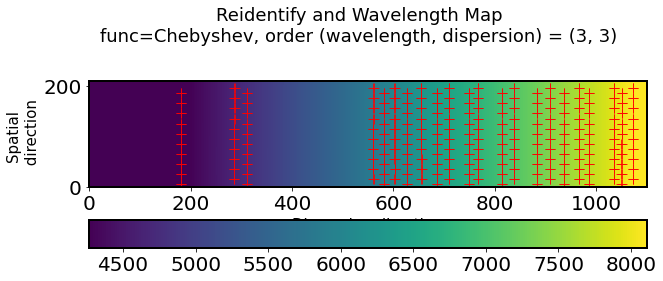

In [343]:
#Plot 2D wavelength callibration map and #Points to used re-identify

fig,ax = plt.subplots(1,1,figsize=(10,4))
ww, ss = np.mgrid[:N_WAVELEN, :N_SPATIAL]
im = ax.imshow(fit2D_REID(ww, ss).T, origin='lower',vmin=4264.4,vmax=8108.99)
ax.plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
fig.colorbar(im, ax=ax,orientation = 'horizontal')

ax.set_ylabel('Spatial \n direction')
ax.set_xlabel('Dispersion direction')
title_str = ('Reidentify and Wavelength Map\n'
+ 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d})')


plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))

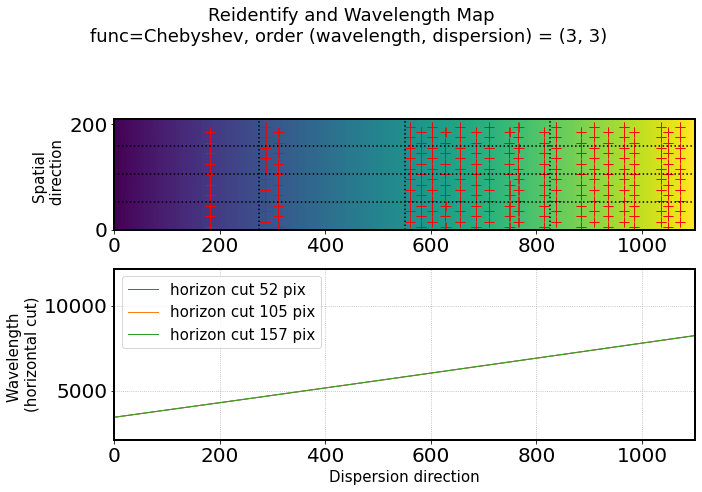

In [344]:
# Check how the dispersion solution change along the spatial axis
# Divide spectrum into 4 equal parts in the spatial direction

fig,ax = plt.subplots(2,1,figsize=(10,7))
ax[0].imshow(fit2D_REID(ww, ss).T, origin='lower')
ax[0].plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
ax[0].set_xlim(0,1100)
ax[0].set_ylabel('Spatial \n direction')

title_str = ('Reidentify and Wavelength Map\n'
+ 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d}) \n')
plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))


for i in (1, 2, 3):
    vcut = N_WAVELEN * i/4
    hcut = N_SPATIAL * i/4
    vcutax  = np.arange(0, N_SPATIAL, STEP_REID) + STEP_REID/2 #Spatial dir coordinate
    hcutax  = np.arange(0, N_WAVELEN, 1) # pixel along dispersion axis
    
    vcutrep = np.repeat(vcut, len(vcutax)) #i/4에 해당하는 dispersion pixel * len(spatial)
    hcutrep = np.repeat(hcut, len(hcutax)) #i/4에 해당하는 spatial pixel * len(dispersion)

    ax[0].axvline(x=vcut, ls=':', color='k')   
    ax[0].axhline(y=hcut, ls=':', color='k')

    ax[1].plot(hcutax, fit2D_REID(hcutax, hcutrep), lw=1, 
             label="horizon cut {:d} pix".format(int(hcut)))
ax[1].set_xlim(0,1100)

ax[1].grid(ls=':')
ax[1].legend()
ax[1].set_xlabel('Dispersion direction')
ax[1].set_ylabel('Wavelength \n(horizontal cut)')
ax[1].set_ylim(min(ID_init['wavelength'])*0.5,max(ID_init['wavelength'])*1.5)


plt.tight_layout()

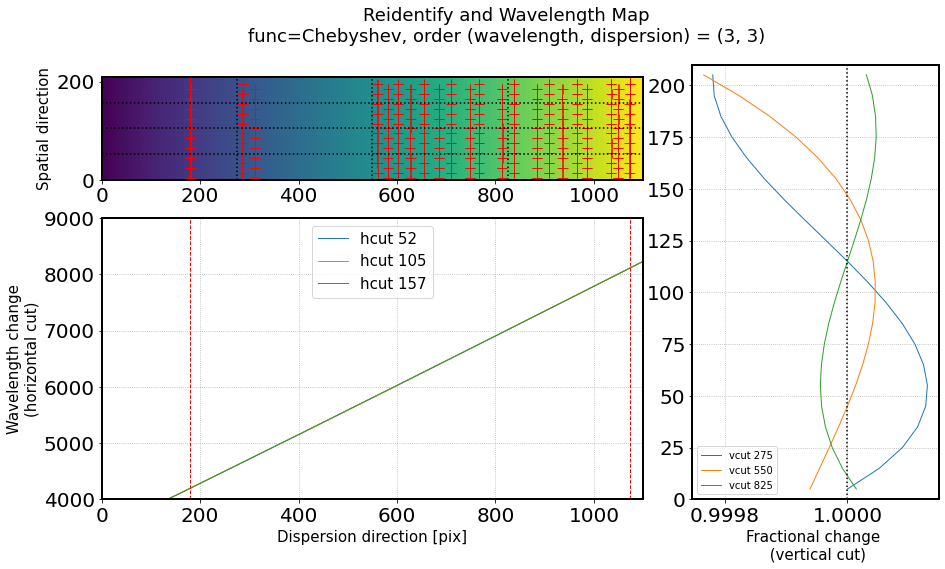

In [345]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[:1, :2])
ax2 = plt.subplot(gs[1:3, :2])
ax3 = plt.subplot(gs[:3, 2])

# title
title_str = ('Reidentify and Wavelength Map\n'
             + 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d})')
plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))



interp_min = line_REID[~np.isnan(line_REID)].min()
interp_max = line_REID[~np.isnan(line_REID)].max()

ax1.imshow(fit2D_REID(ww, ss).T, origin='lower')
ax1.axvline(interp_max, color='r', lw=1)
ax1.axvline(interp_min, color='r', lw=1)
ax1.plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
             alpha=0.8, ms=10)
ax1.set_xlim(0,1100)
ax1.set_ylabel('Spatial \n direction')



for i in (1, 2, 3):
    vcut = N_WAVELEN * i/4
    hcut = N_SPATIAL * i/4
    vcutax  = np.arange(0, N_SPATIAL, STEP_REID) + STEP_REID/2
    hcutax  = np.arange(0, N_WAVELEN, 1)
    vcutrep = np.repeat(vcut, len(vcutax))
    hcutrep = np.repeat(hcut, len(hcutax))

    ax1.axvline(x=vcut, ls=':', color='k')   
    ax1.axhline(y=hcut, ls=':', color='k')

    ax2.plot(hcutax, fit2D_REID(hcutax, hcutrep), lw=1, 
             label="hcut {:d}".format(int(hcut)))

    
    vcut_profile = fit2D_REID(vcutrep, vcutax)
    vcut_normalize = vcut_profile / np.median(vcut_profile)
    
    ax3.plot(vcut_normalize, vcutax, lw=1,
             label="vcut {:d}".format(int(vcut)))



ax2.axvline(interp_max, color='r', lw=1,ls='--')
ax2.axvline(interp_min, color='r', lw=1,ls='--')    
    
ax1.set_ylabel('Spatial direction')
ax2.grid(ls=':')
ax2.legend(fontsize=15)
ax2.set_xlabel('Dispersion direction [pix]')
ax2.set_ylabel('Wavelength change\n(horizontal cut)')

ax3.axvline(1, ls=':', color='k')
ax3.grid(ls=':', which='both')
ax3.set_xlabel('Fractional change \n (vertical cut)')
ax3.legend(fontsize=10)

ax1.set_ylim(0, N_SPATIAL)
ax1.set_xlim(0, N_WAVELEN)
# ax2.set_xlim(300, 1700)
ax2.set_xlim(0, N_WAVELEN)
ax2.set_ylim(4000,9000)
ax3.set_ylim(0, N_SPATIAL)
plt.show()    




<Figure size 3600x2400 with 0 Axes>

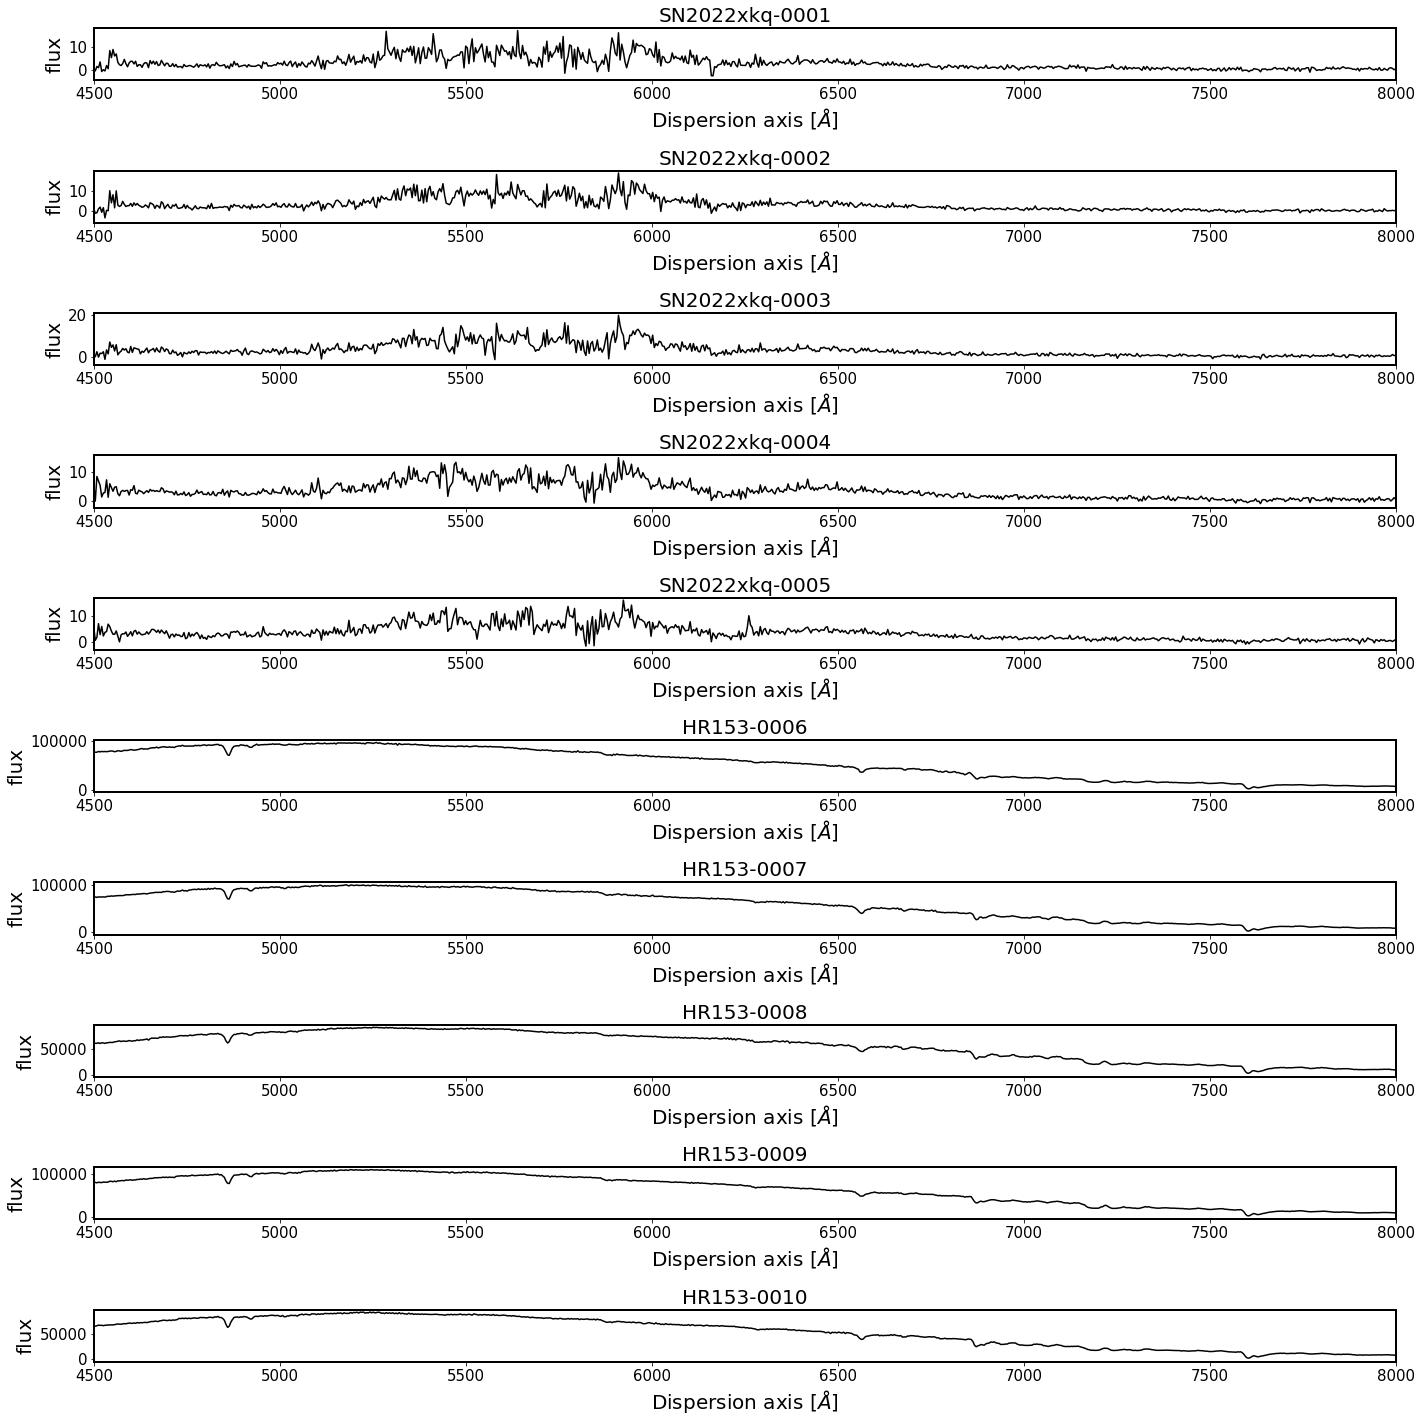

In [465]:
#Plot the spectrum respect to wavelength

Wavelength = chebval(np.arange(len(compimage[0])),coeff_ID)

x_pix = np.arange(len(obj[0]))

ObjStdList = Objectlist + Standlist
fig = plt.figure(dpi =600)
fig, axes = plt.subplots(len(ObjStdList),1,figsize=(20,20))
for i, path in enumerate(ObjStdList):
    OBJECTNAME = path.name
    FILENAME = path.stem
    obj = ascii.read(SUBPATH/('p'+FILENAME+'_inst_spec.csv'))
    ap_summed = obj['ap_summed']
    ap_std = obj['ap_std']
    axes[i].plot(Wavelength, ap_summed, color='k',alpha=1)
    axes[i].set_title(FILENAME, fontsize=20)
    axes[i].set_ylabel('flux', fontsize=20)
    axes[i].set_xlabel(r'Dispersion axis $[\AA]$', fontsize=20) 
    axes[i].tick_params(labelsize=15)
    axes[i].set_xlim(4500, 8000)

    SAVE_FILENAME = SUBPATH/('p'+FILENAME+'_w_spec.csv')

    Data = [Wavelength, ap_summed, ap_std]
    data = Table(Data, names=['wave','inten','std'])
    data['wave'].format = "%.3f" 
    data['inten'].format = "%.3f" 
    data['std'].format = "%.3f" 

    ascii.write(data, SAVE_FILENAME, overwrite=True, format='csv')
    
plt.tight_layout()

# 3. Flux calibration

In [467]:
def _mag2flux(wave, mag, zeropt=48.60):
    '''
    Convert magnitudes to flux units. This is important for dealing with standards
    and files from IRAF, which are stored in AB mag units. To be clear, this converts
    to "PHOTFLAM" units in IRAF-speak. Assumes the common flux zeropoint used in IRAF

    Parameters
    ----------
    wave : 1d numpy array
        The wavelength of the data points
    mag : 1d numpy array
        The magnitudes of the data
    zeropt : float, optional
        Conversion factor for mag->flux. (Default is 48.60)

    Returns
    -------
    Flux values!
    '''

    c = 2.99792458e18 # speed of light, in A/s
    flux = 10.0**( (mag + zeropt) / (-2.5) )
    return flux * (c / wave**2.0)

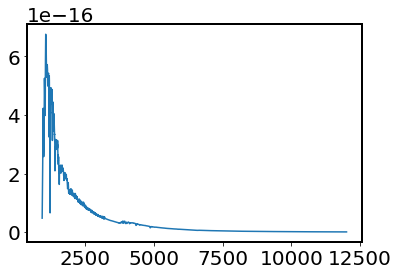

In [474]:
plt.plot(std_wave, std_flux)
#plt.xlim(4000, 10000)

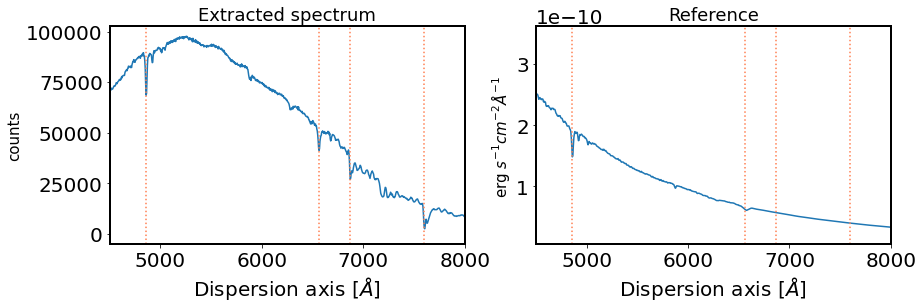

In [565]:

stdfile = SUBPATH/'hr153.csv'
stddata = ascii.read(stdfile)
stddata = stddata[(stddata['wave'] > 4000) & (stddata['wave'] < 9000)]
std_wave, std_flux_16, std_wth  = stddata['wave'], stddata['flux'], 7*np.ones(len(stddata))
std_flux = std_flux_16 * 1e-16

obj = ascii.read(SUBPATH/'pHR153_w_spec.csv')
obj_wave = obj['wave']
obj_flux = obj['inten']

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(obj_wave,obj_flux)
ax[0].set_xlim(4500,8000)
ax[0].set_title('Extracted spectrum')
ax[0].set_ylabel(r'counts')
ax[0].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[1].plot(std_wave,std_flux)
ax[1].set_xlim(4500,8000)
#ax[1].set_ylim(1e-18,3e-17)
ax[1].set_title('Reference')
ax[1].set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax[1].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 

balmer = np.array([6563, 4861, 4341,4100,6867,7593.7], dtype='float')
for i in balmer:
    ax[0].axvline(i,color='coral',ls=':')
    ax[1].axvline(i,color='coral',ls=':')

Text(0, 0.5, '$\\log_{10} \\left( \\frac{reference}{Observed} \\right)$')

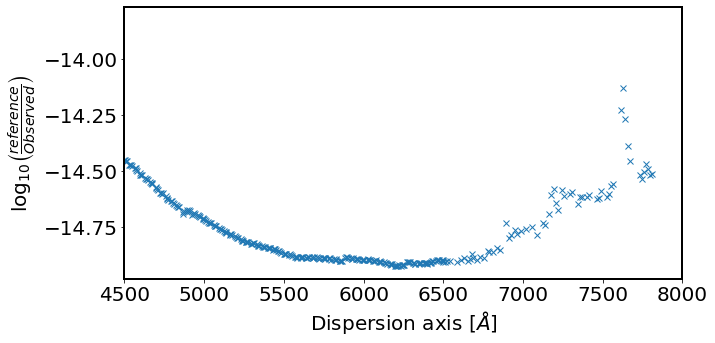

In [566]:
obj_flux_ds = []
obj_wave_ds = []
std_flux_ds = []

for i in range(len(std_wave)):
    rng = np.where((obj_wave >= std_wave[i] - std_wth[i] / 2.0) &
                           (obj_wave < std_wave[i] + std_wth[i] / 2.0)) #STD-wave 범위 안에 들어가는 obj_wave

    IsH = np.where((balmer >= std_wave[i] - std_wth[i] / 2.0) &
                           (balmer < std_wave[i] + std_wth[i] / 2.0))
    
    if (len(rng[0]) > 1) and (len(IsH[0]) == 0): 
        # does this bin contain observed spectra, and no Balmer line?
        # obj_flux_ds.append(np.sum(obj_flux[rng]) / std_wth[i])
        obj_flux_ds.append( np.nanmean(obj_flux[rng]) )
        obj_wave_ds.append(std_wave[i])
        std_flux_ds.append(std_flux[i])
        
ratio = np.abs(np.array(std_flux_ds, dtype='float') /
                       np.array(obj_flux_ds, dtype='float'))
LogSensfunc = np.log10(ratio)


fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(obj_wave_ds,LogSensfunc,marker='x',ls='')
ax.set_xlim(4500,8000)
#ax.set_ylim(-16,-13)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_ylabel(r'$\log_{10} \left( \frac{reference}{Observed} \right)$',fontsize=20) 

Text(0, 0.5, '$\\log_{10} \\left( \\frac{reference}{Observed} \\right)$')

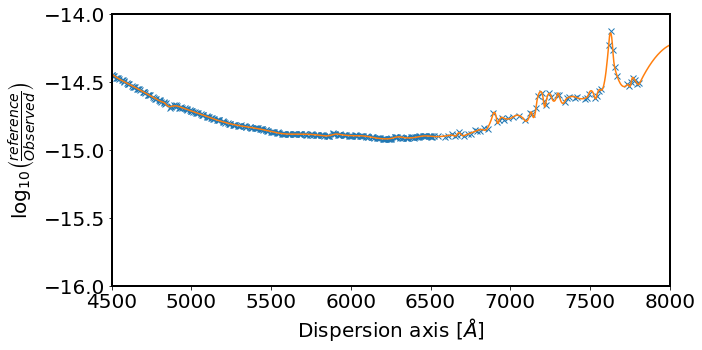

In [567]:
# interpolate back on to observed wavelength grid
spl = UnivariateSpline(obj_wave_ds, LogSensfunc, ext=0, k=2 ,s=0.005)
sensfunc2 = spl(obj_wave)
# SF_CHEB_DEG = 5
# sf_coeff = chebfit(obj_wave_ds, LogSensfunc, deg=SF_CHEB_DEG)
# sensfunc2 = chebval(obj_wave, sf_coeff)

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(obj_wave_ds,LogSensfunc,marker='x',ls='')
ax.plot(obj_wave,sensfunc2)
ax.set_xlim(4500,8000)
ax.set_ylim(-16,-14)
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax.set_ylabel(r'$\log_{10} \left( \frac{reference}{Observed} \right)$',fontsize=20) 

(0.0, 4e-10)

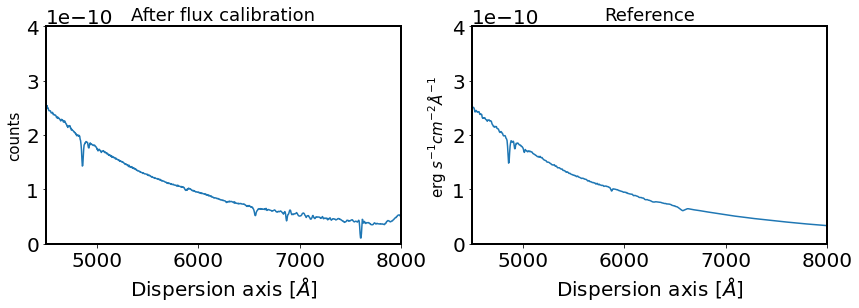

In [568]:
sensfunc = 10**sensfunc2
obj_cal = obj_flux*sensfunc #flux after flux calibration

fig,ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(obj_wave,obj_flux*sensfunc)
ax[0].set_xlim(4500,8000)
ax[0].set_title('After flux calibration')
ax[0].set_ylabel(r'counts')
ax[0].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[0].set_ylim(0,4*10**(-10))
ax[1].plot(std_wave,std_flux)
ax[1].set_xlim(4500,8000)
ax[1].set_title('Reference')
ax[1].set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax[1].set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
ax[1].set_ylim(0,4*10**(-10))


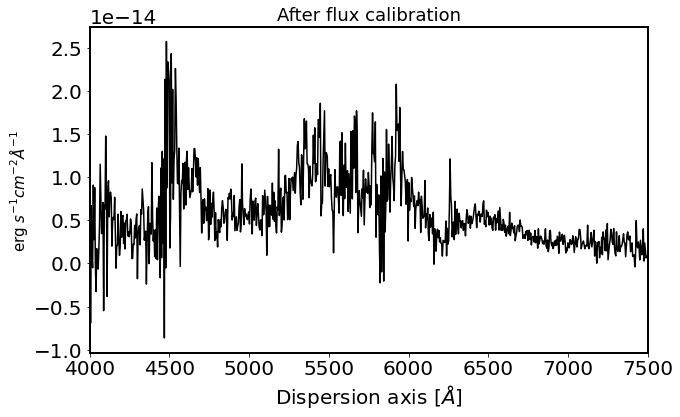

In [580]:
path = Objectlist[4]

tar = ascii.read(SUBPATH/('p'+path.stem+'_w_spec.csv'))
tar_wave = tar['wave']
tar_flux = tar['inten']
tar_cal = tar_flux*sensfunc #flux after flux calibration
tar_std = tar['std']*sensfunc

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(tar_wave,tar_cal,c='k')
ax.set_xlim(4000,7500)
ax.set_title('After flux calibration')
ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
fig.savefig(SUBPATH/('p'+path.stem+'_w_spec.png'))
#ax.set_ylim(0,10*10**(-12))

spectrum = Table([tar_wave, tar_cal, tar_std],
                names=['wave', 'flux', 'error'])
spectrum['wave'].format = "%.3f" 
spectrum['flux'].format = "%.3e" 
spectrum['error'].format = "%.3e"

SPEC_SAVEPATH = SUBPATH/('p'+path.stem+'_wf_spec.csv') 
spectrum.write(SPEC_SAVEPATH, overwrite=True, format='csv')

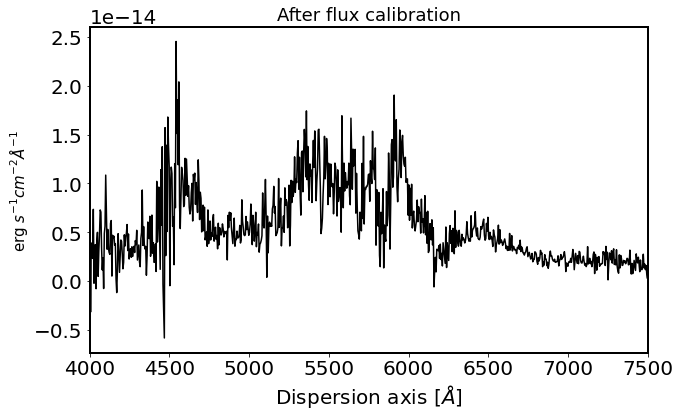

In [583]:
tar = ascii.read(SUBPATH/('pSN2022xkq_w_spec.csv'))
tar_wave = tar['wave']
tar_cal = tar['inten']
tar_std = tar['std']
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(tar_wave,tar_cal,c='k')
ax.set_xlim(4000,7500)
ax.set_title('After flux calibration')
ax.set_ylabel(r'erg $s^{-1}cm^{-2}\AA^{-1}$ ')
ax.set_xlabel(r'Dispersion axis $[\AA]$',fontsize=20) 
fig.savefig(SUBPATH/('p'+path.stem+'_w_spec.png'))